# **afpdb - An Efficient Protein Structure Manipulation Tool**


<img src="https://raw.githubusercontent.com/data2code/afpdb/main/tutorial/img/afpdb.png" width="300">


This document is a tutorial on **afpdb**. Throughout this tutorial, we will use two example antigen-antibody complex structures: 5cil.pdb and fake.pdb. 5cil.pdb contains three chains, L and H chains for the antibody light chain and heavy chain, respectively, and P chain for the antigen. fake.pdb contains two short chains, the L chain contains 4 residues including two with insertion codes and 3 missing residues, and the H chain contains two residues.

This document assumes you are using a Linux environment, however, we expect the notebook can run in other platforms if **afpdb** has been installed.

### Installation
TODO: When the package is considered stable, we need to publish afpdb into pypi, it then simply "pip install afpdb".

For Colab users, please skip this cell.

The instructions below are for users who would like to install **afpdb** locally and for developers.

1. Python
If you do not have Python installed, follow the instructions on https://docs.anaconda.com/free/miniconda/ to install the latest miniconda.
Type command ```python``` should launch the Python programming shell, if it is installed successfully.
2. Install afpdb
```
pip install git+https://github.com/data2code/afpdb.git
```

3. Jupyter Notebook (optional)
To view and run this tutorial, Jupyter should be installed:
```
pip install notebook
```
&emsp;&emsp;Type command ```jupyter notebook``` to lauch the Jupyter Notebook, if it is installed successfully.

&emsp;&emsp;This is no longer needed. However, if the embedded protein structures do not display in Jupyter, install the required plugin:
```
jupyter labextension install jupyterlab_3dmol
```

4. PyMOL (optional)
PyMOL is the preferred application for visualizing protein structures.
Required by examples using ```thread_sequence()``` or `PyMOL()```, install the open source PyMOL:

```
conda install conda-forge::pymol-open-source
```
&emsp;&emsp;In Colab, we also need to run:
```
conda install conda-forge::openssl=3.2.0
```

5. DSSP (optional)
Required for the secondary structure prediction with method ```dssp()```.
```
conda install salislab::dssp
```

&emsp;&emsp;However, in Colab, we need to instead use:

```
conda install ostrokach::dssp
```

6. matplotlib (optional)
Required for the Ramanchondra plot example
```
pip install matplotlib
```

5. Install pytest as a developer
```
pip install pytest
```
&emsp;&emsp;Type command ```pytest``` within the root folder of the afpdb package, you will run all test examples in ```tests\test_all.py```.

&emsp;&emsp;After we patched afpdb code, run ```pytest``` first. Then run ```pip install .``` to update the package under the conda installation.

In [2]:
from pathlib import Path
import os
pwd=Path(os.getcwd())
IN_COLAB=str(pwd)=="/content" # we are in Google Colab
if IN_COLAB:
    pwd=Path("/content/afpdb/tutorial")
    # remove local proxy setting
    os.environ["https_proxy"]=""
    os.environ["http_proxy"]=""
    os.environ["ftp_proxy"]=""
    # install afpdb
    if not os.path.isfile("INSTALL_AFPDB"):
        ! pip install git+https://github.com/data2code/afpdb.git
        ! touch INSTALL_AFPDB
else: # in a local jupyter notebook
    %reload_ext autoreload
    %autoreload 2
    # we assume afpdb has been preinstall

def install_pymol():
    try:
        import pymol2
    except Exception as e:
        if not IN_COLAB:
            print("Please install PyMOL first!")
        else:
            !pip install -q condacolab
            import condacolab
            condacolab.install()
            ! conda install conda-forge::pymol-open-source
            print("Colab does not have openssl 3.2.0, install it...")
            ! conda install conda-forge::openssl=3.2.0
            import pymol2

from afpdb.afpdb import Protein,util,RS,RL,ATS
import numpy as np
import pandas as pd
import re
# two example PDB files used in this tutorial
fn = pwd / "example_files/5cil.pdb"
fk = pwd / "example_files/fake.pdb"

### Demo
To convince you *afpdb* is worth learning, let us look at the following example, where we find binding residues around antigen chain P. We extract all the residues involved in the binding and save them into a separate PDB file. The structure display confirms the extraction was correct. These manipulations are not so straightforward using PyMOL or BioPython.

In [4]:
# load the ab-ag complex structure using PDB code name
p=Protein("5cil")

# show key statistics summary of the structure
p.summary()

--2024-05-28 10:29:06--  https://files.rcsb.org/download/5cil.pdb1.gz
Resolving nibr-proxy.global.nibr.novartis.net (nibr-proxy.global.nibr.novartis.net)... 163.116.128.80
Connecting to nibr-proxy.global.nibr.novartis.net (nibr-proxy.global.nibr.novartis.net)|163.116.128.80|:2011... connected.
Proxy request sent, awaiting response... 200 OK
Length: 151834 (148K) [application/octet-stream]
Saving to: ‘5cil.pdb1.gz’

     0K .......... .......... .......... ..

........ .......... 33% 1.10M 0s
    50K .......... .......... .......... .......... .......... 67% 2.16M 0s
   100K .......... .......... .......... .......... ........  100% 6.38M=0.07s

2024-05-28 10:29:07 (1.94 MB/s) - ‘5cil.pdb1.gz’ saved [151834/151834]



,Chain,Sequence,Length,#Missing Residues,#Insertion Code,First Residue Name,Last Residue Name
0,H,VQLVQSGAEVKRPGSSVTVSCKASGGSFSTYALSWVRQAPGRGLEW...,220,20,14,2,227
1,L,EIVLTQSPGTQSLSPGERATLSCRASQSVGNNKLAWYQQRPGQAPR...,212,0,1,1,211
2,P,NWFDITNWLWYIK,13,0,0,671,683


Notice that residue names do not start from "1" for chain "H" and chain "L" (see column "First Residue Name"), some residues in the CDR regions have insertion code (see column "#Insertion Code"), so residue numbering goes from 1 to 211 for 212 residues on chain "L". We can standardize residue naming:

In [3]:
print("Old P chain residue numbering:", p.rs("P").name(), "\n")
p.renumber("RESTART")
print("New P chain residue numbering:", p.rs("P").name(), "\n")
p.summary()

Old P chain residue numbering: ['671', '672', '673', '674', '675', '676', '677', '678', '679', '680', '681', '682', '683'] 

New P chain residue numbering: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13'] 



,Chain,Sequence,Length,#Missing Residues,#Insertion Code,First Residue Name,Last Residue Name
0,H,VQLVQSGAEVKRPGSSVTVSCKASGGSFSTYALSWVRQAPGRGLEW...,220,20,14,1,226
1,L,EIVLTQSPGTQSLSPGERATLSCRASQSVGNNKLAWYQQRPGQAPR...,212,0,1,1,211
2,P,NWFDITNWLWYIK,13,0,0,1,13


In [4]:
# We can further remove the insertion code by
# renumber() returns a tuple, (Protein obj, old numbers)
p.renumber("NOCODE")[0].renumber("RESTART")
p.summary()

,Chain,Sequence,Length,#Missing Residues,#Insertion Code,First Residue Name,Last Residue Name
0,H,VQLVQSGAEVKRPGSSVTVSCKASGGSFSTYALSWVRQAPGRGLEW...,220,20,0,1,240
1,L,EIVLTQSPGTQSLSPGERATLSCRASQSVGNNKLAWYQQRPGQAPR...,212,0,0,1,212
2,P,NWFDITNWLWYIK,13,0,0,1,13


To predict the structure with AlphaFold, we can replace missing residues with Glycine.

In [5]:
print("Sequence for AlphaFold modeling, with missing residues replaced by Glycine:")
print(">5cil\n"+p.seq(gap="G")+"\n")

Sequence for AlphaFold modeling, with missing residues replaced by Glycine:
>5cil
VQLVQSGAEVKRPGSSVTVSCKASGGSFSTYALSWVRQAPGRGLEWMGGVIPLLTITNYAPRFQGRITITADRSTSTAYLELNSLRPEDTAVYYCAREGTTGDGDLGKPIGAFAHWGQGTLVTVSSASTKGPSVFPLAPSGGGGGGGGGTAALGCLVKDYFPEPVTVGSWGGGGNSGALTSGGVHTFPAVLQSGSGLYSLSSVVTVPSSSLGTGGQGTYICNVNHKPSNTKVDKKGGVEP:EIVLTQSPGTQSLSPGERATLSCRASQSVGNNKLAWYQQRPGQAPRLLIYGASSRPSGVADRFSGSGSGTDFTLTISRLEPEDFAVYYCQQYGQSLSTFGQGTKVEVKRTVAAPSVFIFPPSDEQLKSGTASVVCLLNNFYPREAKVQWKVDNALQSGNSQESVTEQDSKDSTYSLSSTLTLSKADYEKHKVYACEVTHQGLSSPVTKSFNR:NWFDITNWLWYIK



In [5]:
# identify H,L chain residues within 4A to antigen P chain
binder, target, df_dist=p.rs_around("P", dist=4)

# show the distance of binder residues to antigen P chain
df_dist[:5]

,chain_a,resn_a,resn_i_a,resi_a,res_a,chain_b,resn_b,resn_i_b,resi_b,res_b,dist,atom_a,atom_b
408,P,676,676,437,T,H,95,95,97,E,2.636247,OG1,OE2
640,P,674,674,435,D,L,32,32,252,K,2.814822,OD1,NZ
807,P,672,672,433,W,L,94,94,314,S,2.911941,N,OG
767,P,671,671,432,N,L,91,91,311,Y,2.929501,ND2,O
526,P,677,677,438,N,H,100E,100,107,K,3.038573,ND2,CE


In [24]:
p.extract("H:L") p.extract("L:H")

In [1]:
# create a new PDB file only containing the antigen and binder residues
p=p.extract(binder | "P")
# save the new structure into a local PDB file
p.save("binding.pdb")

# display the PDB struture, default is show ribbon and color by chains.
p.show(show_sidechains=True)

NameError: name 'p' is not defined

## Internal Data Structure

### Data Members
To better understand why **afpdb** can manipulate protein structures efficiently, it is helpful to first discuss how the structure data in a PDB file is stored within the AlphaFold's Protein class. The following descriptions are mostly taken from DeepMind’s alphafold/common/protein/protein.py file.
```
  # Cartesian coordinates of atoms in angstroms. The atom types correspond to
  # residue_constants.atom_types, i.e. the first three are N, CA, C.
  atom_positions: np.ndarray  # [num_res, num_atom_type, 3]

  # Amino-acid type for each residue represented as an integer between 0 and
  # 20, where 20 is 'X'.
  aatype: np.ndarray  # [num_res]

  # Binary float mask to indicate presence of a particular atom. 1.0 if an atom
  # is present and 0.0 if not. This should be used for loss masking.
  atom_mask: np.ndarray  # [num_res, num_atom_type]

  # Residue index as used in PDB. It is not necessarily continuous or 0-indexed.
  residue_index: np.ndarray  # [num_res]
```
  *We modified residue_index to dtype "<U6" in order to be able to store residue id with possible insertion code.
  A residue_index was an integer in AlphaFold, in our extension, residue_index can include insertion code, e.g., "121", "122A", "112B".
  The maximum residue id can be 9999 if we allow insertion codes with two letters, otherwise, 99999 if all insertion codes are single letters.*

```
  # 0-indexed number corresponding to the chain in the protein that this residue
  # belongs to.
  chain_index: np.ndarray  # [num_res]

  # B-factors, or temperature factors, of each residue (in sq. angstroms units),
  # representing the displacement of the residue from its ground truth mean
  # value.
  b_factors: np.ndarray  # [num_res, num_atom_type]

  # Chain names - this is added by us. DeepMind's original code does not memorize the chain name in the PDB file
  # chain names became A, B, C, etc. afpdb keeps the original chain names in the PDB file
  chain_id: np.ndarray # [num_chains]
```
  
### Illustration
<img src="img/afpdb_numpy.png">
Notice the first axis of all ndarrays are the number of residues. The second axis can be either one or the number of possible atom types (which is 37).

The above is AlphaFold's Protein class, end users access this data via afpdb's Protein class, which is a wrapper of AlphaFold's protein class.

In afpdb's Protein class, it contains an attribute called ```data```, which points to an AlphaFold's Protein instance.

```
from afpdb import Protein
p=Protein(fk)
print(p.data.atom_positions[:, 1])
#outputs
# [[  6.30200005 -14.27600002 -18.36100006]
# [  9.34000015 -16.29100037 -17.33600044]
# [  9.67800045 -16.51799965 -13.59899998]
# [ 16.89500046 -17.8920002   -7.03000021]
# [ 25.96999931   6.87099981 -19.03800011]
# [ 25.11199951   9.9829998  -16.98600006]]
print(p.res_map)
# outputs
# {'L5': 0, 'L6A': 1, 'L6B': 2, 'L10': 3, 'H3': 4, 'H4': 5}
```

In the example above, we obtain the (X, Y, Z) coordinates of the CA atoms (i.e., we specify 1 for the 2nd axis of ```atom_positions```) corresponding to the first six residues via accessing ```p.data```.

To further speed up structure manipulations, afpdb's Protein class maintains a dictionary ```res_map```, which maps the full residue id, in the format of {chain}{residue_index}, into its residue position. {chain}{residue_index} is the user-friendly format for identifying a specific residue, e.g., "C122A" is the residue index "122A" on chain "C". This residue corresponds to an integer index in the NumPy arrays internally. Developers should remember to call ```self._make_res_map()``` to update this mapping dictionary, if a method requires the underlying mapping to be updated. The example above shows how the six full residue names are mapped to the numpy arrays.

For the rest of the tutorial, when we use the term "Protein" class, we refer to afpdb's Protein class, which can be imported using ```from afpdb.afpdb import Protein```. We will no longer mention AlphaFold's Protein class to avoid confusion, instead, we will use p.data if we need to access the NumPy arrays.

### Example
Let us further explain the previous example and examine examp.data numpy arrays using fake.pdb.

The following is the fake.pdb file, which contains 4-residue chain L and a 2-residue chain H.
```
MODEL     1
ATOM      1  N   GLU L   5       5.195 -14.817 -19.187  1.00  1.00           N
ATOM      2  CA  GLU L   5       6.302 -14.276 -18.361  1.00  1.00           C
ATOM      3  C   GLU L   5       7.148 -15.388 -17.731  1.00  1.00           C
ATOM      4  CB  GLU L   5       5.794 -13.368 -17.248  1.00  1.00           C
ATOM      5  O   GLU L   5       6.658 -16.231 -17.006  1.00  1.00           O
ATOM      6  CG  GLU L   5       6.934 -12.664 -16.494  1.00  1.00           C
ATOM      7  CD  GLU L   5       6.461 -11.817 -15.327  1.00  1.00           C
ATOM      8  OE1 GLU L   5       7.282 -11.138 -14.677  1.00  1.00           O
ATOM      9  OE2 GLU L   5       5.243 -11.804 -15.070  1.00  1.00           O
ATOM     10  N   ILE L   6A      8.444 -15.321 -17.934  1.00  1.00           N
ATOM     11  CA  ILE L   6A      9.340 -16.291 -17.336  1.00  1.00           C
ATOM     12  C   ILE L   6A      9.657 -15.849 -15.925  1.00  1.00           C
ATOM     13  CB  ILE L   6A     10.604 -16.433 -18.162  1.00  1.00           C
ATOM     14  O   ILE L   6A     10.192 -14.739 -15.685  1.00  1.00           O
ATOM     15  CG1 ILE L   6A     10.228 -16.847 -19.590  1.00  1.00           C
ATOM     16  CG2 ILE L   6A     11.540 -17.469 -17.523  1.00  1.00           C
ATOM     17  CD1 ILE L   6A     11.401 -17.319 -20.426  1.00  1.00           C
ATOM     18  N   VAL L   6B      9.339 -16.725 -14.982  1.00  1.00           N
ATOM     19  CA  VAL L   6B      9.678 -16.518 -13.599  1.00  1.00           C
ATOM     20  C   VAL L   6B     11.024 -17.188 -13.330  1.00  1.00           C
ATOM     21  CB  VAL L   6B      8.569 -17.028 -12.666  1.00  1.00           C
ATOM     22  O   VAL L   6B     11.242 -18.372 -13.679  1.00  1.00           O
ATOM     23  CG1 VAL L   6B      8.960 -16.919 -11.194  1.00  1.00           C
ATOM     24  CG2 VAL L   6B      7.268 -16.234 -12.927  1.00  1.00           C
ATOM     40  N   GLN L  10      15.587 -17.776  -7.649  1.00  1.00           N
ATOM     41  CA  GLN L  10      16.895 -17.892  -7.030  1.00  1.00           C
ATOM     42  C   GLN L  10      16.721 -18.330  -5.569  1.00  1.00           C
ATOM     43  CB  GLN L  10      17.616 -16.572  -7.093  1.00  1.00           C
ATOM     44  O   GLN L  10      16.270 -17.557  -4.746  1.00  1.00           O
ATOM     45  CG  GLN L  10      17.963 -16.094  -8.483  1.00  1.00           C
ATOM     46  CD  GLN L  10      18.781 -14.822  -8.460  1.00  1.00           C
ATOM     47  NE2 GLN L  10      20.052 -14.951  -8.083  1.00  1.00           N
ATOM     48  OE1 GLN L  10      18.284 -13.727  -8.786  1.00  1.00           O
ATOM    862  N   LEU H   3      27.368   6.440 -19.107  1.00  1.00           N
ATOM    863  CA  LEU H   3      25.970   6.871 -19.038  1.00  1.00           C
ATOM    864  C   LEU H   3      25.761   7.794 -17.840  1.00  1.00           C
ATOM    865  CB  LEU H   3      25.089   5.647 -18.873  1.00  1.00           C
ATOM    866  O   LEU H   3      25.979   7.398 -16.661  1.00  1.00           O
ATOM    867  CG  LEU H   3      25.225   4.606 -19.964  1.00  1.00           C
ATOM    868  CD1 LEU H   3      24.282   3.430 -19.748  1.00  1.00           C
ATOM    869  CD2 LEU H   3      24.962   5.190 -21.355  1.00  1.00           C
ATOM    870  N   VAL H   4      25.291   9.008 -18.090  1.00  1.00           N
ATOM    871  CA  VAL H   4      25.112   9.983 -16.986  1.00  1.00           C
ATOM    872  C   VAL H   4      23.672  10.399 -16.963  1.00  1.00           C
ATOM    873  CB  VAL H   4      25.976  11.257 -17.222  1.00  1.00           C
ATOM    874  O   VAL H   4      23.143  10.875 -17.973  1.00  1.00           O
ATOM    875  CG1 VAL H   4      25.686  12.319 -16.177  1.00  1.00           C
ATOM    876  CG2 VAL H   4      27.466  10.902 -17.258  1.00  1.00           C
TER     877      VAL H   4
ENDMDL
END
```

We use fake.pdb to better understand the internal data elements.
We first read in fake.pdb, there is a warning indicating there are residues with insertion codes: 6A and 6B. This alerts the user that there may be duplicates in the integer portion of the residue ID, so it is a good habit not to use the assumption that residue integer IDs are all unique. AlphaFold’s original code did not support insertion codes. **afpdb** made modifications to eliminate this limitation.

In [32]:
p=Protein(fk)
print(p.seq_dict())
len(p.rs("ALL"))
p.rs().chain()


{'L': 'EIVXXXQ', 'H': 'LV'}


['L', 'L', 'L', 'L', 'H', 'H']

Our protein object p contains an attribute ```data```, which points to AlphaFold's NumPy arrays. Let us examine the data within ```p.data```.

In [9]:
g=p.data
print(g.residue_index, "\n")
print(p.res_map, "\n")

['5' '6A' '6B' '10' '3' '4'] 

{'L5': 0, 'L6A': 1, 'L6B': 2, 'L10': 3, 'H3': 4, 'H4': 5} 



In this tutorial, **resn** refers to the residue_index, a string with an optional insertion code without chain name. **resi** refers to the internal numpy array indices, e.g., the resi for resn = '6A' is 1. **resn_i** refers to the integer portion of the resn, resn_i for residue 6B is integer 6. ```p.res_map``` maps the unique residue name, (chain + **resn**), into **resi**.

Note: Early afpdb users use ```p.data_prt```, although this is still supported for now, please switch to use ```p.data``` going forward.

In [10]:
print(g.chain_index, "\n")
print(p.chain_id())

[0 0 0 0 1 1] 

['L', 'H']


Chain_index shows the first 4 residues belong to chain index 1, and the next 2 residues belong to chain index 0. AlphaFold uses BioPython to parse PDB files, Chains are numbered in the order of their appearance in the PDB file, so chain L is indexed as chain 0 and chain H is indexed as chain 1. It is important to remember that the best practice is to access data without relying on the assumption that chains appear in a certain order in the PDB or in Protein objects. It is safer to access structure or sequence data by their chain names.

What are the chain names for 0 and 1? AlphaFold’s original code did not store chain names and chains were named as A, B, C, etc. afpdb have improved AlphaFold's code to add a new data member ```chain_id()``` into its Protein class.

There are a total of 6 residues. By assuming residues are numbered sequentially, we imply three residues (7, 8, and 9) are missing in the PDB file. Missing residues are not stored in the NumPy arrays; they can only be inferred based on the gaps in the integer portion of the residue IDs.

In [11]:
# afres contains protein structure constants defined by AlphaFold
import afpdb.myalphafold.common.residue_constants as afres
print(g.aatype, "\n")
[ afres.restypes[x] for x in g.aatype ]

[ 6  9 19  5 10 19] 



['E', 'I', 'V', 'Q', 'L', 'V']

Array ```aatype``` stores the identity of amino acids as defined in alphafold.common.residue_constants.py:

```restypes = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']```

So index 6 translates into “E”.

We will introduce the concept of residue selection later, which enables us to extract residue types for a given residue indexing array without relying on afres:

In [12]:
p.rs([0,1,2,3,4,5]).aa()

['E', 'I', 'V', 'Q', 'L', 'V']

There are a total of 37 possible atom types when all 20 amino acid types are combined (not counting hydrogens), AlphaFold uses an array of 6 x 37 to store atom 3D coordinates. Therefore, the atom_positions is a 3-dimensional NumPy array, where the last dimension is for (X, Y, Z) coordinates:

In [13]:
g.atom_positions.shape

(6, 37, 3)

No residue will have all 37 atoms, They all have N, CA, C, and O, but do not necessarily have CB, CG, etc. Therefore, AlphaFold's code uses more memory than needed to store the coordinates. As PDB data are small, trading extra memory to gain convenience and speed with NumPy arrays is wise. This is why implementing new computations in afpdb can be done quickly, as no bioler-plate for loops are required to navigation the model/chain/residue/atom tree in order to access coordinate data, like what is the required for using the BioPython API.

As not all array members are used, we thus need to know what atoms in the atom_positions array contain real data using a binary array atom_mask:

In [14]:
print(ATS.i('CA'), "\n")
print(g.atom_mask[:, ATS.i('CA')], "\n")
print(g.atom_positions[:, ATS.i('CA')], "\n")
print(g.atom_mask[:, ATS.i('CG')], "\n")
print(g.atom_positions[:, ATS.i('CG')], "\n")

1 

[1. 1. 1. 1. 1. 1.] 

[[  6.30200005 -14.27600002 -18.36100006]
 [  9.34000015 -16.29100037 -17.33600044]
 [  9.67800045 -16.51799965 -13.59899998]
 [ 16.89500046 -17.8920002   -7.03000021]
 [ 25.96999931   6.87099981 -19.03800011]
 [ 25.11199951   9.9829998  -16.98600006]] 

[1. 0. 0. 1. 1. 0.] 

[[  6.93400002 -12.66399956 -16.49399948]
 [  0.           0.           0.        ]
 [  0.           0.           0.        ]
 [ 17.96299934 -16.09399986  -8.4829998 ]
 [ 25.22500038   4.60599995 -19.9640007 ]
 [  0.           0.           0.        ]] 



In [47]:
str(~ p.ats('CA'))

'N,C,CB,O,CG,CG1,CG2,OG,OG1,SG,CD,CD1,CD2,ND1,ND2,OD1,OD2,SD,CE,CE1,CE2,CE3,NE,NE1,NE2,OE1,OE2,CH2,NH1,NH2,OH,CZ,CZ2,CZ3,NZ,OXT'

We refers to an atom with its name instead of memorizing its index in the arrays. ATS is the atom selection class to be introduced later. ```ATS.i``` method converts an atom name into its integer index.

We see that all six residues have CA ($C_{\alpha}$) atom, but only the 1st, 4th, and 5th residues (E, Q, L) have CG ($C_{\gamma}$). So the  coordinates for those atoms within atom_positions array, but with corresponding atom_mask set to 0 should be ignored (these atoms are not present in the PDB structure). Although atoms with coordinates at the origin are likely masked-out atoms, we should not rely on that assumption. In fact, when AlphaFold prediction starts, all atoms are placed at the origin -- so-called black hole conformation. Therefore, we should rely on the atom_mask array to determine the presence of atoms and assume the coordinates of masked out atoms can be any garbage numbers.

Lastly and similarly, b_factors are also stored in an array at the atom level. Only elements with atom_mask equals 1 have meaningful b factors.

In [15]:
g.b_factors.shape

(6, 37)

To summarize, for a given afpdb Protein object p, we store all key PDB information into a few NumPy arrays:
```atom_positions, atom_mask, residue_index, chain_index, b_factors,``` and ```chain_id``` within p.data.
We also have a helper dictionary ```p.res_map```.

These arrays make structure manipulations a breeze.

## Contig
Based on how afpdb uses ndarray to store structure data, we can see to access a few residues and a few atoms is as easy as access certain rows and columns in these ndarrays. To specify what residues are of interest, we use a string format called **contig**. Contig is a string format introduced by recent protein AI packages such as RFDiffusion and ProteinMPNN, we adopt and slightly improve the syntax.

### Single Residue
```RESIDUE = CHAIN RESIDUE_INDEX ``` without a space inbetween

In PDB, each residue is assigned an integer id. In some cases, a residue ID can be followed by an insertion code, which is an alphabet letter. This is because when insertions were made to a residue, such as residue 100 in the antibody CDR loops, people prefer to call the new residues 100A and 100B so that the rest of the residues do not need to be renumbered.

The residue ID alone without the chain name is not unique, because the same residue ID can appear on different chains. Therefore, to fully specify a residue, we include their chain name. For example, a single-residue contig can be H99, H100A. Remember ```p.res_map``` maps a residue contig into its internal array index.

Note: residue index should not contain a negative integer. ***afpdb*** still can read such PDB files, but we should renumber the residues (introduced later) if we want to use the more advanced contig syntax.

### Single Fragment
```FRAGMENT = CHAIN[START ID][-][END ID]```

To specify a continuous range of residues, we specify the start and end residues without the need to enumerate all residues inbetween. The chain name only occurs once in the beginning. The following are all valid contigs: H1-98, H-98, H98-, H, H98-100A, H98-100B, etc. H stands for the whole chain. H-98 has the start residue ID omitted, which means it starts from the first residue (which is not necessarily residue 1, as the numbering can start, e.g., from 5 in the PDB file fk.pdb). H98- covers 98 to the last residue. H98-100A does not include 100B. H98-100B includes both 100A and 100B. A single residue contig is a special fragment contig.

A chain can contain missing residues, e.g., the PDB structure may contain residues 92, 93, 98, 99, 100A, 100B, and 101, where residues 94-97 are missing. H92-99 will select all residues including 92, 93, 98, and 99, i.e., the contig is not broken simply because there maybe missing residues implied.

### Multiple Same-Chain Fragments

To specify multiple fragments within the same chain:

```IN-CHAIN_FRAGMENTS = FRAGMENT[,[START ID][-][END ID]]*```

Chain letter should only appears once. E.g., H-5,10-15 covers residues from the beginning to residue 5 on chain H, followed by residue 10 to residue 15 on the same chain.

Note: Fragments may overlap, however, the only the unique residues end up in the residue selection object to be introduced later. We should avoid overlap, as it creates confusion.

### Multiple Fragments

```CONTIG = IN-CHAIN_FRAGMENTS[:[IN-CHAIN_FRAGMENTS]]*```

We can specify multiple same-chain fragments by concatenating them with ":". An example contig is H-98:L:P2-5, which specifies the whole L chain, H residues from the beginning to residue ID 98, and includes residues in the P chain from 2 to 5. You can certainly describe same-chain fragments using the general contig syntax, e.g., H-5,10-15:L-10 is equivalent to H-5:H10-15:L-10.

If there are multiple fragments within a chain, we should try to keep them together, so that these segments are not separated by segments from other chains. As mentioned later, ```align()```, and ```rmsd()``` do not reorder the underlying residue selection in its arguments, as these methods requires the one-to-one residue mapping of the two lists of input residues. ```extract()``` methods do not reorder residues specified in the contig, however, it requires the all residues of the same chain stay together and ordered ascendingly in the contig string, otherwise, it will generate an error. This is because **afpdb** makes a heavy use of a method called ```chain_pos```, which assumes all residues colocated on the same chain appear sequentially. Do not worry too much as **afpdb** code validates the input contig. Contig strings can be canonicalized, which is described later.

### Special Keywords
None, "ALL" match all residues. "", "NONE", and "NULL" matches no residue.

### Note

As mentioned above, there are multiple ways of describing the same set of residues. Contig strings can be canonicalized using the ```__str__``` method of a residue selection object.

In [16]:
p=Protein(fk)
str(p.rs("L6B,5:L-6B"))

'L5-6B'

# inplace
Many methods support a boolean argument called ```inplace```, this is a practice copied from the well-known Python packaged called Panda.  ```inplace=True``` will modify the original protein object without allocating new memory, while ```inplace=False``` will leave the original object unmodified, but return the modified structure as a new object.

In [17]:
p=Protein(fn)
# inplace=False by default
q=p.extract("H:L")
print(p.chain_id(), q.chain_id(), p==q, "\n")

# p is modified if inplace=True
q=p.extract("H:L", inplace=True)
print(p.chain_id(), q.chain_id(), p==q)

['L', 'H', 'P'] ['H' 'L'] False 

['H' 'L'] ['H' 'L'] True


### Clone
If a method does not support inplace and you would like to keep the original object unmodified, you can first clone a copy:

In [18]:
p=Protein(fn)
print(p.chain_id(), "\n")
q=p.clone()
# we modify q in place
q.extract("P", inplace=True)
# q is modified
print(q.chain_id(), "\n")
# p is untouched
print(p.chain_id())

['L', 'H', 'P'] 

['P'] 

['L', 'H', 'P']


## Selection
Selection is a powerful concept in PyMOL and we support both atom selections and residue selections. We consider the concept of selection is the major feature missing in BioPython accounting for the coding inefficiency in identifying residue/atom of interest by navigating the protein structure tree. **afpdb** stores residues as rows and atoms as columns in the first two axes of the numpy arrays, a residue selection contains the row indices as its data member and an atom selection contains a column index as its data member. Therefore, a residue selection and an atom selection can be used to form a new numpy array with two axes. Notice the same atom selection is shared by all residues, which greatly simplify the usage and backend implementation. We do not support the selection that combines $C_{\alpha}$ from residue 1 and $C_{\beta}$ from residue 2. We do not see this as a limitation in practice.

### Atom Selection

**afpdb** provides a class named ```ATS``` for an atom selection. ```ATS``` has an attribute ```data```, which is a numpy array storing the atom column indices.

There are 37 unique atoms across all 20 amino acids. The syntax for users to select atoms is by providing an atom list, or as a comma-separate string. use either "N,CA,C,O" or ["N","CA","C","O"] for backbone atoms. All atom names are in upper case only.

Internally, atom_positions and atom_mask have 37 elements in their ```axis=1``` dimension, one per atom type. Therefore the atom list is represented as a numpy integer array internally. For "N,CA,C,O", they are represented as ```ats.data = np.array([0, 1, 2, 4)])```, so ```atom_positions[:, ats.data]``` will select the atom coordinates for the 4 backbone atoms. This is a key benefit of using numpy to store PDB structural data.

Note: We often use "ats" for an atom selection object, since the word "as" is a reserved word in python.

In [19]:
print(ATS("N,CA,C,O"), "\n")
print("ATS data member:", ATS("N,CA,C,O").data, "\n")
print(ATS(["CA","C","N","O"]), "\n")
print(ATS("CA,CA"), "\n")
print("ALL", ATS("ALL"), "\n")
print(None, ATS(None), "\n")
print("Empty string, NONE, NULL", ATS("").data, ATS("NONE").data, ATS("NULL").data, "\n")

N,CA,C,O 

ATS data member: [0 1 2 4] 

N,CA,C,O 

CA 

ALL N,CA,C,CB,O,CG,CG1,CG2,OG,OG1,SG,CD,CD1,CD2,ND1,ND2,OD1,OD2,SD,CE,CE1,CE2,CE3,NE,NE1,NE2,OE1,OE2,CH2,NH1,NH2,OH,CZ,CZ2,CZ3,NZ,OXT 

None N,CA,C,CB,O,CG,CG1,CG2,OG,OG1,SG,CD,CD1,CD2,ND1,ND2,OD1,OD2,SD,CE,CE1,CE2,CE3,NE,NE1,NE2,OE1,OE2,CH2,NH1,NH2,OH,CZ,CZ2,CZ3,NZ,OXT 

Empty string, NONE, NULL [] [] [] 



As shown above, the order of the atoms does not matter and dupliates are removed and column indices are sorted. We have also special keywords: None and "ALL" for selecting all atoms, "", "NONE", and "NULL" for an empty selection. You can also initialize an ATS object with a set/list/tuple/pandas.Series of atom strings, a numpy array, another ATS object. If a single integer is provided, it is treated as one atom index. Basically, ATS supports all sensible input formats.

If a method expect an ATS object as an argument, we can provide the value using any of the format that can be used to initialize an ATS object. For developers, the first thing the method should do is to cast the input argument into an ATS object using the following idiom:

```ats=ATS(ats)```

We can also create an ATS object from a Protein object, so that you can avoid explicitly using the ATS class:

In [20]:
p=Protein()
ats=p.ats("N,CA,C,O")
print(ats, "\n")
print(p.ats([0,1,2,3]), "\n")
print(len(ats), "\n")
# not_full can be empty or less than 37 atoms
print(ats.is_empty(), ats.is_full(), ats.not_full(), "\n")
# method i() converts an atom name into its integer index
print(ATS.i("CA"), ATS.i("CB"), "\n")
# in operator
print("N" in ats, "CB" in ats, 2 in ats, "\n")

print(p.ats_not("N,CA,C,O"), "\n")
print(p.ats2str(ATS("N,C,CA,O")), "the same as", str(ATS("N,C,CA,O")), "\n")

N,CA,C,O 

N,CA,C,CB 

4 

False False True 

1 3 

True False True 

CB,CG,CG1,CG2,OG,OG1,SG,CD,CD1,CD2,ND1,ND2,OD1,OD2,SD,CE,CE1,CE2,CE3,NE,NE1,NE2,OE1,OE2,CH2,NH1,NH2,OH,CZ,CZ2,CZ3,NZ,OXT 

N,CA,C,O the same as N,CA,C,O 



We also support the set operations &, |, ~ (not), + (the same as |), - (a-b means in a but not in b):

In [21]:
ats1=ATS("N,CA,C,O")
ats2=ATS("C,O,CB")
print("or:", ats1 | ats2, "\nsame as +:", ats1+ats2, "\n")
print("and:", ats1 & ats2, "\n")
print("minus:", ats1 - ats2, "\n")
print("not:", ~ats1, "\nnot not:", ~~ats1, "\n")

or: N,CA,C,CB,O 
same as +: N,CA,C,CB,O 

and: C,O 

minus: N,CA 

not: CB,CG,CG1,CG2,OG,OG1,SG,CD,CD1,CD2,ND1,ND2,OD1,OD2,SD,CE,CE1,CE2,CE3,NE,NE1,NE2,OE1,OE2,CH2,NH1,NH2,OH,CZ,CZ2,CZ3,NZ,OXT 
not not: N,CA,C,O 



### Residue Selection
We use a contig string previously described to select residues. To create a residue selection use the ```rs()``` method. As the total number of residues equals the ```axis=0``` dimension of ```atom_positions``` and ```atom_mask``` arrays, a residue selection object contains a ```data``` member, which is literally an integer numpy.ndarray. E.g., rs.data=np.array([0,1,9]). Therefore, ```atom_positions[rs.data, ATS('N,CA,C,O').data]``` will capture the 3D coordinates of the 4 backbone atoms for residue 1st, 2nd, and 10th.

The following is an example where we only extract the backbone atoms from chain H and L and save them into a new PDB file.

In [136]:
p=Protein(fn)
p.extract("H-5:L-5", ats="C,CA,N,O", inplace=True)
p.save("bb.pdb")
print("\n".join(util.read_list("bb.pdb")[:15])+"\n...\n")
print(p.rs_missing_atoms(), "\n")
p.show(style="stick", show_sidechains=True)

HEADER    AFPDB PROTEIN                           24-May-24   XXXX              
MODEL     1                                                                     
ATOM      1  N   VAL H   1      32.582   3.997 -22.715  1.00  1.00           N  
ATOM      2  CA  VAL H   1      31.113   4.261 -22.594  1.00  1.00           C  
ATOM      3  C   VAL H   1      30.727   4.737 -21.206  1.00  1.00           C  
ATOM      4  O   VAL H   1      30.948   4.033 -20.247  1.00  1.00           O  
ATOM      5  N   GLN H   2      30.105   5.899 -21.101  1.00  1.00           N  
ATOM      6  CA  GLN H   2      29.676   6.451 -19.826  1.00  1.00           C  
ATOM      7  C   GLN H   2      28.215   6.827 -20.036  1.00  1.00           C  
ATOM      8  O   GLN H   2      27.888   7.435 -21.037  1.00  1.00           O  
ATOM      9  N   LEU H   3      27.368   6.440 -19.107  1.00  1.00           N  
ATOM     10  CA  LEU H   3      25.970   6.871 -19.038  1.00  1.00           C  
ATOM     11  C   LEU H   3  

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Because we only have backbone atoms, all residues (except Gly, which fake.pdb does not have) have missing atoms.

Similar to ATS, RS can be initiatlized by a contig str, special keywords (None, "ALL" for all residues and "", "NONE", "NULL" for an empty selection). RS can also be initialized with a set/list/tuple/pandas.Series, a numpy array, another RS object or RL object (explained later). If a single integer is provided, it is treated as one residue index. Basically, RS supports all sensible input formats.

If a method expects an RS object as an argument, we should implement it in a way that users can provide the selection object using any of the data format that can be used to initialize an RS object. E.g., we can write ```p.extract("H")```, ```p.extract([0,1,2,3])```, ```p.extract(np.array([2,4,6]))```, ```p.extract((2,4,6))```, or ```p.extract(p.rs("H"))```, etc. The contig is the most popular format. For developers, the first thing the method should do is to cast the input argument into an RS object using the following idiom:

```rs=RS(self, rs)```

Unlike ATS, RS requires a Protein object as its first argument in the initialization, as a residue selection will not be meaningful without being tied to a protein structure. For this reason, we often create an RS object from a Protein object using ```p.rs()``` instead:

In [23]:
# residue selections
p=Protein(fn)
rs1=RS(p, "H1-3")
rs2=RS(p, "H3-5:L-3")
print("1st rs:", rs1)
print("2nd rs:", rs2, "\n")
# however, we prefer to create an RS object using Protein.rs() method
rs1=p.rs("H1-3")
rs2=p.rs("H3-5:L-3")
print("1st rs:", rs1)
print("2nd rs:", rs2, "\n")
# Protein also provides set operations on rs objects
print("and:", p.rs_and(rs1, rs2), "\n")
print("or:", p.rs_or(rs1, rs2), "\n")
# as we not H:L, the only residues left are P chain residues
print("not:", p.rs_not("H:L"), p.data.chain_index[p.rs_not("H:L").data], "\n")
# we can specify the residue universe using full_set, this can reduce the size of rs_not
# in the example below, we restrict the not selection within chain L
print("not with full set:", p.rs_not("L-100", rs_full="L"), "\n")
print("notin:", p.rs_notin(rs1, rs2), "\n")
print(p.rs2str(p.rs_or(rs1, rs2)))

1st rs: H1-3
2nd rs: L1-3:H3-5 

1st rs: H1-3
2nd rs: L1-3:H3-5 

and: H3 

or: L1-3:H1-5 

not: P [2 2 2 2 2 2 2 2 2 2 2 2 2] 

not with full set: L101-111 

notin: H1-2 

L1-3:H1-5


In **afpdb**, our convention is any method name starts with ```rs_``` is expected to return a RS object (or a list of RS objects in ```rs_seq()```) and any argument named ```rs``` or starts with ```rs_``` should take any residue selection formats whenever possible.

Residue selection behaves like a set, where residue indices within ```rs.data``` are uniqued and sorted. All sensible set operations apply, therefore, instead of using p.rs_or, p.rs_and, we prefer to use set operators directly as shown below:

In [24]:
p=Protein(fn)
# an unusal selection
rs1=p.rs("H1-3")
rs2=p.rs("H3-5:L-3")
print("and:", rs1 & rs2, "\n")
print("or:", rs1 | rs2, "same as", rs1+rs2, "\n")
print("not:", ~ p.rs("H:L"), "\n")
# ~ cannot take additional argument, so we need to use _not(), if rs_full needs to be specified
print("not with full set:", p.rs("L-100")._not(rs_full="L"), "\n")
print("notin:", rs1-rs2, "\n")
# inplace operations
rs1+=rs2
print(rs1, "\n")
rs1-=rs2
print(rs1, "\n")

and: H3 

or: L1-3:H1-5 same as L1-3:H1-5 

not: P 

not with full set: L101-111 

notin: H1-2 

L1-3:H1-5 

H1-2 



In [25]:
# more
p=Protein(fn)
print(p.rs("").is_empty(), "\n")
print(p.rs("ALL").is_full(), "\n")
print(p.rs(None).is_empty(), p.rs(None).is_full(), "\n")
print(p.rs("H").is_full(), p.rs("H").is_empty(), "\n")

# to combine a list of selections
rs1=p.rs("H1-3")
rs2=p.rs("H3-5:L-3")
rs3=p.rs("H:P")
rs_list=[rs1, rs2, rs3]
print(RS._or(*rs_list), "\n")
# AND on the list
print(RS._and(*rs_list), "\n")

# only the first element of the list needs to be an RS object, the rest can be any format
# we need to extract the Protein object from the first RS object
print(RS._or(rs1, "H", "P"), "\n")

# residue lookup, convert a residue name to its internal AlphaFold residue order number
print(RS.i("GLY"), RS.i("Gly"), RS.i("G"), "\n")


True 

True 

False True 

False False 

L1-3:H:P 

H3 

H:P 

7 7 7 



## Residule List
Residue indices within a RS object, ```rs.data```, are unique and sorted. We sometimes need duplicate residue indices or require indices to be in specific order. Residule List (RL) class is the parent class of RS, which serves the purpose.

In [26]:
p=Protein(fn)
rl=p.rl("H3-5:L-3:H1-3")
print("Not sorted and not unique:", rl.data, "\n")
# compared to residue list
rs=p.rs("H3-5:L-3:H1-3")
print("Unique and ordered:", rs.data, "\n")
# cast between RS and RL
# notice we need to provide a protein object as the first arugment, when we use RS or RL to create the object
print(RS(rl.p, rl), "\n")

print("Sorted and unique:", p.rs(rl).data, "\n")
print(p.rl(p.rs("H3-5:L-3:H1-3")).data, "\n")

WARNING> contig should keep the segments for the same chain together H1-3, if possible!
Not sorted and not unique: [113 114 115   0   1   2 111 112 113] 

WARNING> contig should keep the segments for the same chain together H1-3, if possible!
Unique and ordered: [  0   1   2 111 112 113 114 115] 

L1-3:H1-5 

Sorted and unique: [  0   1   2 111 112 113 114 115] 

WARNING> contig should keep the segments for the same chain together H1-3, if possible!
[  0   1   2 111 112 113 114 115] 



Residue list is handy to extract annotations for the residues:

In [27]:
p=Protein(fk)
rl=p.rl("H:L:H")
df=pd.DataFrame({"resi": rl.data})
df['chain']=rl.chain()
df['resn']=rl.name()
df['resni']=rl.namei()
df['aa']=rl.aa()
df['unique_name']=rl.unique_name()
df

WARNING> contig should keep the segments for the same chain together H, if possible!


,resi,chain,resn,resni,aa,unique_name
0,4,H,3,3,L,H3
1,5,H,4,4,V,H4
2,0,L,5,5,E,L5
3,1,L,6A,6,I,L6A
4,2,L,6B,6,V,L6B
5,3,L,10,10,Q,L10
6,4,H,3,3,L,H3
7,5,H,4,4,V,H4


In the above example, we introduce a few terms:

* resi: the internal integer residue index used as the row index of backend numpy arrays
* chain: the chain name of the residue
* resn: the residue index, may include an insertion code, such as "6A" and "6B" in this example.
* resni: the integer part of the residue index without insertion code. This is integer type and can be used for sorting.
* aa: amino acid letter
* unique_name/contig: the unique residue name: {chain}{residue_index}

Later we will see residue list is also used in aligning two structures, as we would like to present the one-to-one mapping between residues.

## Read/Write

The convenience of afpdb can be demonstrated by how we read/write protein structures.

In [28]:
p=Protein(fn)
print(p.chain_id())
p.save("test.pdb")
out=util.unix("ls -l test.pdb")

['L', 'H', 'P']
-rw-rw-r-- 1 zhoyyi1 ux_nbc_ds 155520 May 24 19:55 test.pdb


The constructor can optionally take a contig string if you want to only read in a subset of the structure:

In [29]:
p=Protein(fn, contig="H:L")
print(p.chain_id(), "\n")
p=Protein(fn, contig="H-5:L-10")
print(p.seq(), "\n")

# however, for clarity, we recommend to separate the two operations, use contig in the extract() method explicitly.
p=Protein(fn)
print(p.extract("H:L").chain_id(), "\n")
p=Protein(fn)
print(p.extract("H-5:L-10").seq(), "\n")

['H' 'L'] 

VQLVQ:EIVLTQSPGT 

['H' 'L'] 

VQLVQ:EIVLTQSPGT 



The first argument in Protein() constructor can be quite flexible. Just be aware that only the first model is read, if the PDB file contains multiple models. AlphaFold was not designed to handle multiple conformations, afpdb can be made much more efficient by assuming only one conformation is being manipulated.

Below are a few examples:

In [30]:
print("Load a local PDB file")
# support both .pdb and .ent extensions
print(fn)
p=Protein(fn)
print(p.chain_id(), "\n")

print("Create Protein from another afpdb.Protein object")
q=Protein(p)
print(q.chain_id(), "\n")

print("Create Protein from an afpdb.Protein.data object")
q=Protein(p.data)
print(q.chain_id(), "\n")

print("Create Protein from a BioPython Structure object")
b=p.to_biopython()
print(type(b))
q=Protein(b)
print(q.chain_id(), "\n")

print("Create Protein from a str containing the content of a PDB file")
s=p.to_pdb_str()
print("\n".join(s.split("\n")[:5])+"\n...")
q=Protein(s)
print(q.chain_id())

Load a local PDB file
/da/NBC/ds/zhoyyi1/afpdb/tutorial/example_files/5cil.pdb
['L', 'H', 'P'] 

Create Protein from another afpdb.Protein object
['L' 'H' 'P'] 

Create Protein from an afpdb.Protein.data object
['L' 'H' 'P'] 

Create Protein from a BioPython Structure object
<class 'Bio.PDB.Structure.Structure'>
['L', 'H', 'P'] 

Create Protein from a str containing the content of a PDB file
HEADER    AFPDB PROTEIN                           24-May-24   XXXX              
MODEL     1                                                                     
ATOM      1  N   GLU L   1       5.195 -14.817 -19.187  1.00  1.00           N  
ATOM      2  CA  GLU L   1       6.302 -14.276 -18.361  1.00  1.00           C  
ATOM      3  C   GLU L   1       7.148 -15.388 -17.731  1.00  1.00           C  
...
['L', 'H', 'P']


In [137]:
# more examples ...
print("Save as .cif, save Protein into a .cif file\n")
p=Protein(fn)
p.save("test.cif")
print("Create Protein from a local .cif file")
p=Protein("test.cif")
print(p.chain_id(), "\n")
print("Create with a PDB 4-letter code, fetch structure from PDB online.")
p=Protein("1crn")
print(p.seq(), "\n")
print("Create with a EMBL AlphaFold model code, fetch structure from EMBL online.")
p=Protein("Q2M403")
print(p.seq())
p.show()

Save as .cif, save Protein into a .cif file

Create Protein from a local .cif file
['L' 'H' 'P'] 

Create with a PDB 4-letter code, fetch structure from PDB online.


--2024-05-24 19:59:28--  https://files.rcsb.org/download/1crn.pdb1.gz
Resolving nibr-proxy.global.nibr.novartis.net (nibr-proxy.global.nibr.novartis.net)... 163.116.128.80
Connecting to nibr-proxy.global.nibr.novartis.net (nibr-proxy.global.nibr.novartis.net)|163.116.128.80|:2011... connected.
Proxy request sent, awaiting response... 200 OK
Length: 7740 (7.6K) [application/octet-stream]
Saving to: ‘1crn.pdb1.gz’

     0K .......                                               100% 3.40M=0.002s

2024-05-24 19:59:29 (3.40 MB/s) - ‘1crn.pdb1.gz’ saved [7740/7740]



TTCCPSIVARSNFNVCRLPGTPEAICATYTGCIIIPGATCPGDYAN 

Create with a EMBL AlphaFold model code, fetch structure from EMBL online.


--2024-05-24 19:59:29--  https://alphafold.ebi.ac.uk/files/AF-Q2M403-F1-model_v3.pdb
Resolving nibr-proxy.global.nibr.novartis.net (nibr-proxy.global.nibr.novartis.net)... 163.116.128.80
Connecting to nibr-proxy.global.nibr.novartis.net (nibr-proxy.global.nibr.novartis.net)|163.116.128.80|:2011... connected.
Proxy request sent, awaiting response... 200 OK
Length: 294110 (287K) [application/octet-stream]
Saving to: ‘AF-Q2M403-F1-model_v3.pdb’

     0K .......... .......... .......... .......... .......... 17%  630K 0s
    50K .......... .......... .......... .......... .......... 34% 1.02M 0s
   100K .......... .......... .......... .......... .......... 52%  495K 0s
   150K .......... .......... .......... .......... .......... 69%  940K 0s
   200K .......... .......... .......... .......... .......... 87%  552K 0s
   250K .......... .......... .......... .......              100%  972K=0.4s

2024-05-24 19:59:30 (700 KB/s) - ‘AF-Q2M403-F1-model_v3.pdb’ saved [294110/294110]



MVVVSLQCAIVGQAGSSFDVEIDDGAKVSKLKDAIKAKNATTITGDAKDLQLFLAKQPVEDESGKEVVPVYRPSAEEMKEESFKWLPDEHRAALKLVEGESDDYIHALTAGEPILGSKTLTTWFYTKNNMELPSSEQIHVLVVVPDGAGGSASDTSRMDRLFDKVDKVYEHTVLSKRTRYVHSEMNSAKGNILLNDLKIRISPVDTVKFAGGVPTPAKEFKWKSDRTEEQQKEPYREYVVANIGDVLTNNKLCVVGVEKGANILTVEVPGRDIVLAGRTDMIVLSDIAQKFPHYLPHLPGVRMLIEVKKVVTTASEFQALSELIALDIIVTESVMALLTNLTNHWQFFWVSRKSDDRVIIETTTLIAPGEAFAVIRTLLDQSPSAGAEVSLPCFEKPVKRQKLSQLLPSISEASGSSGIRESIERYYDIASMLGPDLEMARAVASQVARSIPTLSYFS


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [32]:
p=Protein(fn)
p.seq()

'EIVLTQSPGTQSLSPGERATLSCRASQSVGNNKLAWYQQRPGQAPRLLIYGASSRPSGVADRFSGSGSGTDFTLTISRLEPEDFAVYYCQQYGQSLSTFGQGTKVEVKRTV:VQLVQSGAEVKRPGSSVTVSCKASGGSFSTYALSWVRQAPGRGLEWMGGVIPLLTITNYAPRFQGRITITADRSTSTAYLELNSLRPEDTAVYYCAREGTTGDGDLGKPIGAFAHWGQGTLVTVSS:NWFDITNWLWYIK'

Notice the sequences from different chains are concatenated by colon (color in red) into one line:

EIVLTQSPGTQSLSPGERATLSCRASQSVGNNKLAWYQQRPGQAPRLLIYGASSRPSGVADRFSGSGSGTDFTLTISRLEPEDFAVYYCQQYGQSLS<br>
TFGQGTKVEVKRTV<span style="color:red;">**:**</span>VQLVQSGAEVKRPGSSVTVSCKASGGSFSTYALSWVRQAPGRGLEWMGGVIPLLTITNYAPRFQGRITITADRSTSTAYLEL<br>
NSLRPEDTAVYYCAREGTTGDGDLGKPIGAFAHWGQGTLVTVSS<span style="color:red;">**:**</span>NWFDITNWLWYIK

This is a standard format used to provide multimer sequence inputs to ColabFold and AlphaFold for protein structure prediction.

Here the order of the chain sequences is the same as how they occur in the PDB file. However, it is always safer to assume that chain order may change when we convert objects among different formats. Therefore, we strongly recommend users tie chain names with their sequences by using ```seq_dict()``` method instead:

In [33]:
p.seq_dict()

{'L': 'EIVLTQSPGTQSLSPGERATLSCRASQSVGNNKLAWYQQRPGQAPRLLIYGASSRPSGVADRFSGSGSGTDFTLTISRLEPEDFAVYYCQQYGQSLSTFGQGTKVEVKRTV',
 'H': 'VQLVQSGAEVKRPGSSVTVSCKASGGSFSTYALSWVRQAPGRGLEWMGGVIPLLTITNYAPRFQGRITITADRSTSTAYLELNSLRPEDTAVYYCAREGTTGDGDLGKPIGAFAHWGQGTLVTVSS',
 'P': 'NWFDITNWLWYIK'}

### Missing Residues
When there are missing residues in the structure, they will be represented as "X" in the sequence string:

In [34]:
p=Protein(fn)
q=p.extract("H1-10:H21-30")
print(q.data.residue_index, "\n")
print("Number of residues in numpy arrays:", q.data.atom_positions.shape, "\n")
print(q.seq(), "\n")
print(q.seq_dict(gap="."), "\n")
print(q.seq().replace("X", "G"), "\n")
print(q.seq(gap="G"), "\n")

['1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '21' '22' '23' '24' '25' '26'
 '27' '28' '29' '30'] 

Number of residues in numpy arrays: (20, 37, 3) 

VQLVQSGAEVXXXXXXXXXXCKASGGSFST 

{'H': 'VQLVQSGAEV..........CKASGGSFST'} 

VQLVQSGAEVGGGGGGGGGGCKASGGSFST 

VQLVQSGAEVGGGGGGGGGGCKASGGSFST 



The number of missing residues is determined based on residue numbering. In this example, we first create a new object by taking the first ten residues from chain H, skipping 10 residues, then take another 10 residues. In the resultant object q, the 10-residue gap is preserved (residue index jumps from 10 to 21). Although the 10 missing residues haves no corresponding elements in the internal numpy array representation (the array only contains 20 residue in total, the discontinuity in the residue index allows us to figure out that 10 residues are missing. Therefore, ```seq()``` and ```seq_dict()``` outputs ten "X". You can change the display of "X" by the gap argument or suppress gap by "". For protein structure prediction, we often replace the missing residues by Glycine "G".

In [35]:
p=Protein(fk)
print(p.data.residue_index, "\n")
print(p.seq_dict(), "\n")
print(p.seq_dict(gap=""))

['5' '6A' '6B' '10' '3' '4'] 

{'L': 'EIVXXXQ', 'H': 'LV'} 

{'L': 'EIVQ', 'H': 'LV'}


When we determine missing residues, only the integer part of the residue ID is considered. In the above example, residue index 6 appears twice as 6A and 6B, followed by residue 10. We assume residues 7, 8, and 9 are missing.

Note: Missing residues at the N or C terminals cannot be recovered. In addition, if the residue numbering in the full structure are not mumerically continous, e.g., both residues "6A" and "6B" were removed, we can only infer that one residue "6" is missing:

In [36]:
p=Protein(fk)
q=p.extract("L5,10:H")
print(q.data.residue_index, "\n")
print(q.seq(), "\n")

['5' '10' '3' '4'] 

EXXXXQ:LV 



### Length
The get the total number of residues (not counting missing residues), i.e, the number of rows in the backend numpy arrays, use:

In [37]:
p=Protein(fn)
print("Total residue counts:", len(p), "\n")
print("Residue counts per chains:", p.len_dict())
q=Protein(fk)
# missing residues are not counted as part of the length
print(q.seq(), "\n")
print(q.len_dict(), "\n")

Total residue counts: 250 

Residue counts per chains: {'L': 111, 'H': 126, 'P': 13}
EIVXXXQ:LV 

{'L': 4, 'H': 2} 



### Search
When we have a sequence fragment and would like to locate where it came from, use:

In [38]:
p=Protein(fn)
out=p.rs_seq('LTI')
for i,m in enumerate(out):
    print(f"Matched #{i+1}, location: {m}, sequence: {m.seq()}")

Matched #1, location: L74-76, sequence: LTI
Matched #2, location: H54-56, sequence: LTI


The name ```rs_seq()``` suggests the method performs sequence search and return residue selection (RS) objects. Since there can be multiple matches, it returns a list of RS objects. We will explain residue selection objects later, for now, we just need to know that a residue selection object can be printed as a contig string and its ```seq()``` method returns the corresponding sequence.

The two matches are in bold below:
EIVLTQSPGTQSLSPGERATLSCRASQSVGNNKLAWYQQRPGQAPRLLIYGASSRPSGVADRFSGSGSGTDFT***LTI***SRLEPEDFAVYYCQQYGQSLSTFGQGTKVEVKRTV:
VQLVQSGAEVKRPGSSVTVSCKASGGSFSTYALSWVRQAPGRGLEWMGGVIPL***LTI***TNYAPRFQGRITITADRSTSTAYLELNSLRPEDTAVYYCAREGTTGDGDLGKPIGAFAHWGQGTLVTVSS:
NWFDITNWLWYIK

If we are only interested in sequence search within a list of chains, provide the chain name(s) list:

In [39]:
out=p.rs_seq('LTI', in_chains="H")
print(len(out), out[0], "\n")

1 H54-56 



The sequence search pattern can be a regular expression, e.g., to match all charged residues:

In [40]:
out=p.rs_seq(r'[RHKDE]')
# concatenate the list of matched residue selection objects into one RS object, RS._or() will be explained later.
m=RS._or(*out)
print(m.seq())

EERRKRRRDRDREEDKEKREKRKRRERRDREREDREDDKHDK


### Mutagenesis

To perform mutagenesis on a structure, we thread a new sequence onto an existing Protein object.
As this method requires the installation of PyMOL, it throws an exception if PyMOL is not found.

When we specify the new sequence, we only specify the new residues for which there is coordinate information, i.e., missing residues should not occur in the new sequence. Chain L's sequence was EIVXXXQ, the target sequence is AIVD instead of AIVXXXD.

The following example requires PyMOL to be installed. The installation can take some time in Google Colab.

In [138]:
install_pymol()
p=Protein(fk)
print(p.seq(), "\n")
p.thread_sequence({"L":"AIVD", "H":"LG"}, "m.pdb")

EIVXXXQ:LV 

MUTATE PyMOL> Old  L 5 GLU >>> New ALA
Selected!
PyMOL>refresh_wizard
 ExecutiveRMSPairs: RMSD =    0.047 (4 to 4 atoms)
 Mutagenesis: no rotamers found in library.
MUTATE PyMOL> Old  L 10 GLN >>> New ASP
Selected!
PyMOL>refresh_wizard
 ExecutiveRMSPairs: RMSD =    0.027 (4 to 4 atoms)
 Mutagenesis: no phi/psi, using backbone-independent rotamers.
 Mutagenesis: 9 rotamers loaded.
 Rotamer 9/9, strain=2.82
MUTATE PyMOL> Old  H 4 VAL >>> New GLY
Selected!
PyMOL>refresh_wizard
 ExecutiveRMSPairs: RMSD =    0.023 (3 to 3 atoms)
 Mutagenesis: no rotamers found in library.
m.pdb
{'L': 'AIVD', 'H': 'LG'}
###JSON STARTS
{"output_pdb": "m.pdb", "ok": true, "output_equal_target": false, "input": {"L": "EIVQ", "H": "LV"}, "output": {"H": "LG", "L": "AIVXXXD"}, "target": {"L": "AIVD", "H": "LG"}, "relax": false, "residues_with_missing_atom": "", "mutations": [["L", 5, "GLU", "ALA"], ["L", 10, "GLN", "ASP"], ["H", 4, "VAL", "GLY"]]}
###JSON END


{'output_pdb': 'm.pdb',
 'ok': True,
 'output_equal_target': False,
 'input': {'L': 'EIVQ', 'H': 'LV'},
 'output': {'H': 'LG', 'L': 'AIVXXXD'},
 'target': {'L': 'AIVD', 'H': 'LG'},
 'relax': False,
 'residues_with_missing_atom': '',
 'mutations': [('L', 5, 'GLU', 'ALA'),
  ('L', 10, 'GLN', 'ASP'),
  ('H', 4, 'VAL', 'GLY')]}

From the output JSON data, we see L5 was "E" and it is replaced with "A". L6A-L6B was not changed, therefore, their side chain coordinates remain the same. L10 is replaced by "D". On the chain H, H6 was "G" and is replaced by "V".

The new mutated residues have their side chain torsion angles generated by PyMOL. Therefore, it generally makes sense to relax the side chain, for example, with Amber. Relax is not supported by afpdb due to its dependency on Amber.
TODO: we might look into this more.

### Mutation
If a chain name is in two proteins and the chain has the same number of residuees, we can identify mutated residues by a residue-by-residue comparison. The example below identify three mutated residues:

In [42]:
p=Protein(fk)
# m.pdb was produced with the previous thread_seq() example
q=Protein("m.pdb")
print(p.seq(), q.seq(), "\n")
print(p.rs_mutate(q))

EIVXXXQ:LV LG:AIVXXXD 

L5,10:H4


## Chain
### Chain Name and Order
In the fn PDB file, chains go from L, to H, to P.
chain_id() will return chain names in the same order. ```p.data.chain_index``` stores the chain index. **afpdb** expects all residues belong to the same chain are stored together without being interrupted by another chain.

In [43]:
p=Protein(fn)
print(p.chain_id(), "\n")
print(p.data.chain_index, "\n")

['L', 'H', 'P'] 

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2] 



Although we should not rely on the exact order of chains in the PDB file, we can neverthess reorder chains, if we wish:

In [44]:
p=Protein(fn)
q=p.data
print("Original chain order:", p.chain_id(), "\n")
print(p.seq(), "\n")
print(q.chain_index[-20:], "\n")
print(q.residue_index[-20:], "\n")

p.reorder_chains(["P","L","H"])
q=p.data
print("After chain reorder:", p.chain_id(), "\n")
print(p.seq(), "\n")
print(q.chain_index[-20:], "\n")
print(q.residue_index[-20:], "\n")

# reorder_chains is actually no longer needed, as we can use extract():
p=Protein(fn)
p.extract("P:L:H", inplace=True)
q=p.data
print("After chain reorder:", p.chain_id(), "\n")
print(p.seq(), "\n")
print(q.chain_index[-20:], "\n")
print(q.residue_index[-20:], "\n")

Original chain order: ['L', 'H', 'P'] 

EIVLTQSPGTQSLSPGERATLSCRASQSVGNNKLAWYQQRPGQAPRLLIYGASSRPSGVADRFSGSGSGTDFTLTISRLEPEDFAVYYCQQYGQSLSTFGQGTKVEVKRTV:VQLVQSGAEVKRPGSSVTVSCKASGGSFSTYALSWVRQAPGRGLEWMGGVIPLLTITNYAPRFQGRITITADRSTSTAYLELNSLRPEDTAVYYCAREGTTGDGDLGKPIGAFAHWGQGTLVTVSS:NWFDITNWLWYIK 

[1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2] 

['120' '121' '122' '123' '124' '125' '126' '1' '2' '3' '4' '5' '6' '7' '8'
 '9' '10' '11' '12' '13'] 

After chain reorder: ['P', 'L', 'H'] 

NWFDITNWLWYIK:EIVLTQSPGTQSLSPGERATLSCRASQSVGNNKLAWYQQRPGQAPRLLIYGASSRPSGVADRFSGSGSGTDFTLTISRLEPEDFAVYYCQQYGQSLSTFGQGTKVEVKRTV:VQLVQSGAEVKRPGSSVTVSCKASGGSFSTYALSWVRQAPGRGLEWMGGVIPLLTITNYAPRFQGRITITADRSTSTAYLELNSLRPEDTAVYYCAREGTTGDGDLGKPIGAFAHWGQGTLVTVSS 

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2] 

['107' '108' '109' '110' '111' '112' '113' '114' '115' '116' '117' '118'
 '119' '120' '121' '122' '123' '124' '125' '126'] 

After chain reorder: ['P' 'L' 'H'] 

NWFDITNWLWYIK:EIVLTQSPGTQSLSPGERATLSCRASQSVGNNKLAWYQQRPGQA

Notice that extract() method will error if the selection list contains duplicates or residues of the same chance are not ordered.

In [45]:
p=Protein(fn)
try:
    p.extract("H:H:L")
except Exception as e:
    print(e)

try:
    p.extract("H5-:H1")
except Exception as e:
    print(e)

try:
    p.extract("H1:L:H2")
except Exception as e:
    print(e)

# as_rl=False, all examples are fine, b/c the contig selection will be cast into an unordered/non-redundant residue selection
print("Treat as residue selection ...\n")
q=p.extract("H:H:L", as_rl=False)
q=p.extract("H5-:H1", as_rl=False)
q=p.extract("H1:L:H2", as_rl=False)



There are duplicate residues: [111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128
 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164
 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182
 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200
 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218
 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236]
Residues within chain H are not sorted in order.
WARNING> contig should keep the segments for the same chain together H2, if possible!
Residues for chain ['H'] are not grouped together.
Treat as residue selection ...

WARNING> contig should keep the segments for the same chain together H2, if possible!


After reordering, the ```chain_index``` array goes from 0 to 2, and the chain_id list has also been updated.

### Residue Index
The method ```chain_pos()``` is an important utility method. It returns the start and end ndarray indices of each chain, which can be used to access the corresponding numpy arrays. For our example structure, the complex consists of 3 chains. The array residue_index has 250 elements. The residues in chain L are stored as the first 111 elements in the numpy arrays, in Python, the indices are from 0 to 110.

Many methods relies on ```chain_pos``` to accelerate the computation, this is the reason why **afpdb** assumes all residues of the same chain should be stored together within the backend numpy arrays.

In [46]:
p=Protein(fn)
print(p.chain_pos(), "\n")
q=p.data
print(q.residue_index[108:114], "\n")
print(q.chain_index[108:114])

{'L': [0, 110], 'H': [111, 236], 'P': [237, 249]} 

['109' '110' '111' '1' '2' '3'] 

[0 0 0 1 1 1]


The chain_index for element 110 is the last residue of chain L, its residue id is '111' and chain id is 0, i.e., resn="111", resi=110, resn_i=111. Element 111 is the first residue of chain H. Its residue id is '1' and chain id is 1, i.e., resn="1", resi=111, resn_i=1.

If we only want to extract the coordinates for the 13 residues of chain P, we will use:

In [47]:
q.atom_positions[237:250].shape

(13, 37, 3)

### Residue Renumbering

Residue index can be modified. There are a number of renumbering modes:
```
    None: keep original numbering unmodified.
    RESTART: 1, 2, 3, ... for each chain
    CONTINUE: 1 ... 100, 101 ... 140, 141 ... 245
    GAP200: 1 ... 100, 301 ... 340, 541 ... 645 # mimic AlphaFold gaps
    You can define your own gap by replacing GAP200 with GAP{number}, e.g., GAP10
    NOCODE: remove insertion code, residue 6A and 6B becomes 6, 7
```

In [48]:
p=Protein(fk)
q=p.data
print(q.chain_index, "\n")

p._renumber(None)
print(q.residue_index, "\n")

p._renumber('RESTART')
print(q.residue_index, "\n")

p._renumber('CONTINUE')
print(q.residue_index, "\n")

p._renumber('GAP200')
print(q.residue_index, "\n")

p._renumber('GAP10')
print(q.residue_index, "\n")

p._renumber('NOCODE')
print(q.residue_index)

[0 0 0 0 1 1] 

['5' '6A' '6B' '10' '3' '4'] 

['1' '2A' '2B' '6' '1' '2'] 

['1' '2A' '2B' '6' '7' '8'] 

['1' '2A' '2B' '6' '207' '208'] 

['1' '2A' '2B' '6' '17' '18'] 

['1' '2' '3' '7' '8' '9']


We generally do not need to call renumbering directly, as it is a utility method used by other methods. This is why the method name starts with "_". NOCODE is used to remove insertion code, in case we need to feed a structure into a tool that cannot deal with insertion code. Notice "2A" and "2B" are renamed to "2" and "3" to avoid the collision, then residue "6" is renamed to "7" to preserve the three missing residues in the original naming.

### Merge & Split Chains

Before AlphaFold Multimer was created, we had to use AlphaFold monomer model to predict multimer structures. The hack is to merge chains into one single chain, where we introduce a 200 gap in the residue indices between the original chain junctions to keep AlphaFold from treating the previous C- and the next N-terminals of two contiguous chains from being mistakenly treated as neighboring residues. This could be achieved by:

In [49]:
p=Protein(fn)
q, c_pos=p.merge_chains(gap=200, inplace=False)
print(q.seq_dict(gap="."), "\n")
print(c_pos, "\n")

r=q.split_chains(c_pos, inplace=False)
print(r.seq_dict())

{'L': 'EIVLTQSPGTQSLSPGERATLSCRASQSVGNNKLAWYQQRPGQAPRLLIYGASSRPSGVADRFSGSGSGTDFTLTISRLEPEDFAVYYCQQYGQSLSTFGQGTKVEVKRTV........................................................................................................................................................................................................VQLVQSGAEVKRPGSSVTVSCKASGGSFSTYALSWVRQAPGRGLEWMGGVIPLLTITNYAPRFQGRITITADRSTSTAYLELNSLRPEDTAVYYCAREGTTGDGDLGKPIGAFAHWGQGTLVTVSS........................................................................................................................................................................................................NWFDITNWLWYIK'} 

{'L': [0, 110], 'H': [111, 236], 'P': [237, 249]} 

{'L': 'EIVLTQSPGTQSLSPGERATLSCRASQSVGNNKLAWYQQRPGQAPRLLIYGASSRPSGVADRFSGSGSGTDFTLTISRLEPEDFAVYYCQQYGQSLSTFGQGTKVEVKRTV', 'H': 'VQLVQSGAEVKRPGSSVTVSCKASGGSFSTYALSWVRQAPGRGLEWMGGVIPLLTITNYAPRFQGRITITADRSTSTAYLELNSLRPEDTAVYYCAREGTTGDGDLGKPIGAFAHWGQGTLVTVSS', 'P': 'NWFDITNWLWYIK'}


As chains got merged into a single change, 200-residue gaps were introduced and shown as "." in the sequence output. We notice there is only one chain, where the first chain name in the original PDB file was used. The method returns the original ```c_pos``` object, which memorizes the chain structure before the merge.

After AlphaFold predicts the structure as a monomer, the output PDB file can then be used by split_chains to restore the original trimer structure. Here ```c_pos``` guides the method to split the monomer chain and restores the naming of the original chains.

Note: When we generate sequence for AlphaFold prediction, we need to use Glycine for the gap. As the predicted structure will contain 200 extra glycine, those need to be removed before we ```split_chains()```. The extra glycines can be identified with ```q.rsi_missing()```, as demonstrated later in the first AI use case.

TODO: use this trick, let's use gap=100 to create method fold() that use Meta's web serivce to predict a multimer structure.

### Select Neighboring Residues
For a given residue selection, rs_around selects neighboring residues, where their closest distance is within the specified dist argument.
In the example below, we find all residues that are within 3.5A around P chain residues. AlphaFold's NumPy arrays do not contain hydrogens. We compute distances among all possible atom pairs and use the minimum atom-atom distance as the final distance between two residues. In this example, it identifies 5 residues on chain L and 8 residues on chain H. The method does not consider intra-selection distances, i.e., it will not include residues that are already part of the seed selection. If you want to include seed residues, just use use "or" operator to combine two residue selections.

There are two returned values, the first is a new residue selection of the neighboring residues and the second is a dataframe object. The dataframe object provides the details about all residues pairs, the source is marked as "a" (chain P here) and the target is marked as "b" (chain H or L). resn_ stands for residue name, resn_i_ is for the integer part of the residue names without the insertion code and it is an integer type. resi_ is for the internal numpy array index (i.e., residue selection ```rs.data```). The shortest distance between two residues is listed under the *dist* column and the atom pair that contributes to this shortest distance is listed as *atom_a* and *atom_b*. The dataframe is sorted by descending *dist* values.

In [50]:
p=Protein(fn)
rs_nbr, rs_seed, t=p.rs_around("P", dist=3.5)
print(rs_nbr.name(), "\n")
print(rs_nbr)
t

['33', '92', '93', '94', '95', '30', '56', '58', '98', '106', '107', '108', '109'] 

L33,92-95:H30,56,58,98,106-109


,chain_a,resn_a,resn_i_a,resi_a,res_a,chain_b,resn_b,resn_i_b,resi_b,res_b,dist,atom_a,atom_b
551,P,6,6,242,T,H,98,98,208,E,2.636247,OG1,OE2
16,P,4,4,240,D,L,33,33,32,K,2.814822,OD1,NZ
157,P,2,2,238,W,L,95,95,94,S,2.911941,N,OG
117,P,1,1,237,N,L,92,92,91,Y,2.929501,ND2,O
656,P,7,7,243,N,H,108,108,218,K,3.038573,ND2,CE
143,P,1,1,237,N,L,94,94,93,Q,3.087493,OD1,C
469,P,2,2,238,W,H,56,56,166,I,3.230981,NE1,O
130,P,1,1,237,N,L,93,93,92,G,3.257804,ND2,C
633,P,10,10,246,W,H,106,106,216,L,3.305220,NE1,O
495,P,2,2,238,W,H,58,58,168,N,3.320923,CE3,ND2


To include the seed residues in the selection, use the following idiom:

In [51]:
# p.rs(t.resi_a) select all seed residues appears in the neighbor table
# resi_a contains the residue IDs for those on the P chain that interact with rs_nbr
rs_both = rs_nbr | rs_seed
print(rs_nbr, "\n")
print(p.rs(t.resi_a), "\n")
print(rs_both)

L33,92-95:H30,56,58,98,106-109 

P1-4,6-7,10 

L33,92-95:H30,56,58,98,106-109:P1-4,6-7,10


The distance table contains all residues pairs between seeds and their neighbors. If we only want to see one seed per neighbor, we define drop_duplicates = True:

In [52]:
rs_nbr, rs_seed, t2=p.rs_around("P", dist=3.5, drop_duplicates=True)
print(rs_seed, "\n")
print(rs_nbr)
t2

P1-4,6-7,10 

L33,92-95:H30,56,58,98,106-109


,chain_a,resn_a,resn_i_a,resi_a,res_a,chain_b,resn_b,resn_i_b,resi_b,res_b,dist,atom_a,atom_b
551,P,6,6,242,T,H,98,98,208,E,2.636247,OG1,OE2
16,P,4,4,240,D,L,33,33,32,K,2.814822,OD1,NZ
157,P,2,2,238,W,L,95,95,94,S,2.911941,N,OG
117,P,1,1,237,N,L,92,92,91,Y,2.929501,ND2,O
656,P,7,7,243,N,H,108,108,218,K,3.038573,ND2,CE
143,P,1,1,237,N,L,94,94,93,Q,3.087493,OD1,C
469,P,2,2,238,W,H,56,56,166,I,3.230981,NE1,O
130,P,1,1,237,N,L,93,93,92,G,3.257804,ND2,C
633,P,10,10,246,W,H,106,106,216,L,3.305220,NE1,O
495,P,2,2,238,W,H,58,58,168,N,3.320923,CE3,ND2


Note: we need to be careful about using drop_duplicates=True, as we may get fewer residues in the ```resi_a``` column (not in this example). Say a seed residue X is never the closest residue to any neighboring residues. Then X will be removed from the returned distance table, if drop_duplicates=True. The selection idiom ```rs_nbr | p.rs(dist.resi_a)``` will miss residue X, as X is not the immedidate neighbor to ```rs_nbr```.

The reason we provide resn_i is to enable us to filter the output dataframe. The data type for resn is a string, as resn could contain insertion codes. If we are interested in rows corresponding to residues in H95-106, we cannot use the *resn* column for filtering. Instead, we can accomplish this with the *resn_i* column:

In [53]:
print("resn cannot be used for filtering, as it's string type, str greater than '95' will be all less than '116'")
t2=t[(t.chain_b=="H")&(t.resn_b>="95")&(t.resn_b<="106")]
t2

resn cannot be used for filtering, as it's string type, str greater than '95' will be all less than '116'


,chain_a,resn_a,resn_i_a,resi_a,res_a,chain_b,resn_b,resn_i_b,resi_b,res_b,dist,atom_a,atom_b


In [54]:
print("resn_i is an integer column")
t2=t[(t.chain_b=="H")&(t.resn_i_b>=95)&(t.resn_i_b<=106)]
t2

resn_i is an integer column


,chain_a,resn_a,resn_i_a,resi_a,res_a,chain_b,resn_b,resn_i_b,resi_b,res_b,dist,atom_a,atom_b
551,P,6,6,242,T,H,98,98,208,E,2.636247,OG1,OE2
633,P,10,10,246,W,H,106,106,216,L,3.305220,NE1,O


By default, all residue atoms are considered. However, we can restrict the distance measurement using an atom selection. We can also restrict the target residues using a residue selection ```rs_within```.

In [55]:
p=Protein(fn)
rs=p.rs("P")
# select residues on chain H that have CA-CA distance within 8A.
rs_nbr, rs_seed, t=p.rs_around(rs, dist=8, rs_within="H", ats="CA")
print(rs_nbr)
t

H30-32,51,58,108-111


,chain_a,resn_a,resn_i_a,resi_a,res_a,chain_b,resn_b,resn_i_b,resi_b,res_b,dist,atom_a,atom_b
444,P,3,3,239,F,H,111,111,221,G,5.573195,CA,CA
422,P,7,7,243,N,H,109,109,219,P,5.704927,CA,CA
70,P,6,6,242,T,H,31,31,141,Y,5.911184,CA,CA
57,P,6,6,242,T,H,30,30,140,T,6.083017,CA,CA
412,P,10,10,246,W,H,108,108,218,K,6.221307,CA,CA
409,P,7,7,243,N,H,108,108,218,K,6.447024,CA,CA
421,P,6,6,242,T,H,109,109,219,P,6.487135,CA,CA
83,P,6,6,242,T,H,32,32,142,A,6.735140,CA,CA
60,P,9,9,245,L,H,30,30,140,T,6.884907,CA,CA
248,P,2,2,238,W,H,58,58,168,N,7.062018,CA,CA


## Display
To visualize a structure, please ```save``` it to a PDB file and use PyMOL. If you prefer to display the structure in an HTML file, use ```util.save_string("my_protein.html", p.html())``` and open it in a browser.

Within Jupyter Notebook, p.show() will display the structure as we do in this notebook.

The arguments for show() and html() are the same.
```show_sidechains=False, show_mainchains=False, color="chain", style="cartoon", width=320, height=320)```

color can be: "chain", "lDDT", "b", "spectrum", "ss".
style can be: "cartoon", "stick", "line", "sphere", "cross"

If colored by lDDT, the b-factors should be in the range of [0, 100]. If colored by "b", b-factors should be normalized to [0, 1].

In [139]:
p=Protein(fn)
util.save_string("my_protein.html", p.html())
print("You can also open my_protein.html in a browser to view the protein structure.")
print("We display the protein within Jupyter notebook below")
p.show(style="cartoon", color="ss")

You can also open my_protein.html in a browser to view the protein structure.
We display the protein within Jupyter notebook below


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

### B-factors
B-factor is an embedded attribute that can be repurposed to store other computation results. E.g., AlphaFold uses b-factors to store pLDDT for the structure prediction confidence. we can use b-factors to flag the CDR loop residues. PyMOL can then color residues by b-factors, which enables us to visualize the computational results in their structural context.

In [57]:
p=Protein(fk)
# read b_factors as a numpy array
print(p.b_factors())
# set b_factors by providing a numpy array
import numpy as np
p.b_factors(np.random.random((len(p))), "\n")

[1. 1. 1. 1. 1. 1.]


array([0.86352092, 0.03666677, 0.40852814, 0.34639552, 0.03657171,
       0.36985766])

To color by b-factors, set ```color = "b"``` in the show() method. However, please normalize b-factor ndarray to be within [0, 1] to get the expected coloring effect.

In [48]:
p=Protein(fn)
n=len(p)
p.data_prt.b_factors[:,:]=np.sin(np.arange(n)/n*np.pi).reshape(-1,1)
p.show(style="cartoon", color="b")

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

It may be more convenient to get or set b-factors for each chain, as one array containing all residues from all chains can be troublesome to use. We can use b_factors_by_chain to achieve this.

In [143]:
# in this example, we color residues based on how far they are from the P chain
p=Protein(fn)
rs, rs_seed, dist=p.rs_around("P", dist=1e8, drop_duplicates=True)
# important to sort the residues by their internal indices, so that the order of distance matches the internal b-factor array
# we use drop_duplicates=True to make sure each residue only occur once (to its nearest seed residue)
dist.sort_values("resi_b", inplace=True)
assert len(dist)==len(p.extract("H:L"))
d_min,d_max=dist.dist.min(), dist.dist.max()
# b factors should be in [0, 1], if we want to color by b-factos.
dist["dist"]=(dist["dist"]-d_min)/(d_max-d_min)
b={"P":np.zeros(len(p.rs("P"))), "H":dist[dist.chain_b=="H"].dist.values, "L":dist[dist.chain_b=="L"].dist.values}
# set b_factors
p.b_factors_by_chain(b)
p.show(color="b")

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

We can also provide a residue selection for ```b_factors()```.

In [49]:
# Use b-factor to mimic color by chain
p=Protein(fn)
# provide b-factors as an array
p.b_factors(np.zeros(len(p.rs("H"))), rs="H")
# a number is considered a special case
p.b_factors(0.5, rs="L")
p.b_factors(1, rs="P")
p.show(color="b")

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [50]:
# visualize CDRs
p=Protein(fn)
# CDR sequence (Chothia definition) light chains followed by heavy chain
CDR_L=['RASQSVGNNKLA', 'GASSRPS', 'QQYGQSLST']
CDR_H=['GGSFSTY', 'IPLLTI', 'EGTTGDGDLGKPIGAFAH']
# color the framework resdues
p.b_factors(1, "H")
p.b_factors(0.9, "L")
p.b_factors(0.8, "P")
for i,(seq,chain) in enumerate(zip(CDR_L+CDR_H, ["L"]*3+["H"]*3)):
    b=i/20
    # we select the CDR fragment by sequence search
    rs_cdr=p.rs_seq(seq, in_chains=[chain])[0]
    p.b_factors(b, rs=rs_cdr)
p.show(color="b")

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

We can leverage PyMOL to create more powerful visualizations, which will be described later.

## Geometry & Measurement

### Distance
In a previous example, ```rs_around``` method already uses the distance measurement method ```rs_dist``` internally.

Given two residue groups, ```rs_a``` and ```rs_b```, ```rs_dist``` computes the distance between all residue pairs. The distance is determined based on the two closest atoms. The output dataframe is sorted by distance and indicates which atom pair contributes to the distance measure.

In [62]:
p=Protein(fk)
print(p.seq_dict())
print(p.rs().name(), "\n")

t=p.rs_dist('L', 'H')
t.display()
print("\n")
# we restricted the distance measurement to CA-CA distance, notice the distance are now longer
t=p.rs_dist('L', 'H', ats='CA')
t.display()

{'L': 'EIVXXXQ', 'H': 'LV'}
['5', '6A', '6B', '10', '3', '4'] 

    chain_a    resn_a      resn_i_a    resi_a  res_a    chain_b      resn_b    resn_i_b    resi_b  res_b       dist  atom_a    atom_b
--  ---------  --------  ----------  --------  -------  ---------  --------  ----------  --------  -------  -------  --------  --------
 3  L          10                10         3  Q        H                 3           3         4  L        21.2251  OE1       CD1
 0  L          5                  5         0  E        H                 3           3         4  L        22.9552  OE1       CD1
 1  L          6A                 6         1  I        H                 3           3         4  L        23.3484  O         CD1
 2  L          6B                 6         2  V        H                 3           3         4  L        25.339   C         CD1
 7  L          10                10         3  Q        H                 4           4         5  V        25.5449  OE1       N
 4  L        

Instead of residue distance, we can also measure the distance between all-atom combinations. Our ultimate aim in the future is to add a column for interaction types, such as clash, electrostatic, hydrogen bonds, etc. Please contact us, if you have the knowledge in how to define that.

In [63]:
# We list distances between all atom pairs of two residues
p=Protein(fk)
t=p.atom_dist('L6A', 'H3')
t[:10].display()
print(f"\n... total rows: {len(t)}\n")

# We list distances between all backbone atom pairs of two residues
t=p.atom_dist('L6A', 'H3', ats=['CA','C','N','O'])
t.display()

     chain_a    resn_a      resn_i_a    resi_a  res_a    chain_b      resn_b    resn_i_b    resi_b  res_b       dist  atom_a    atom_b
---  ---------  --------  ----------  --------  -------  ---------  --------  ----------  --------  -------  -------  --------  --------
448  L          6A                 6         1  I        H                 3           3         4  L        23.3484  O         CD1
447  L          6A                 6         1  I        H                 3           3         4  L        24.169   CB        CD1
456  L          6A                 6         1  I        H                 3           3         4  L        24.4316  CD1       CD1
446  L          6A                 6         1  I        H                 3           3         4  L        24.4987  C         CD1
451  L          6A                 6         1  I        H                 3           3         4  L        24.578   CG2       CD1
444  L          6A                 6         1  I        H          

### RMSD
To measure the RMSD between two residue selections, we first translate one molecule by 5Å, then call rmsd(). The method ```rmsd``` takes a target object, source residue list, target residue list, and optionally an atom selection.

In [64]:
p=Protein(fk)
q=p.translate([3.0,4.0,0.0], inplace=False)
print(p.center(), q.center(), p.center()-q.center(), "\n")
# consider all matched atoms, rs='ALL' or rs=None mean all residues
print(q.rmsd(p, None, None), "\n")
# consider CA only
print(q.rmsd(p, ats='CA'))

[ 15.54949999  -8.0205001  -15.39166681] [ 18.54949999  -4.0205001  -15.39166681] [-3. -4.  0.] 

5.000000001 

5.000000001


The two selections should have the same number of residues, unless one selection has only one residue. Otherwise, it will error. Make sure the order of residues in the two selections is what you want, as the distance is computed for each residue pairwise in order. If two residues are of different types, only the common atoms are used, which is enforced by the atom_mask array. If we have different residue types, we recommend users use ```ats``` to explicitly restrict the computation to the backbone atoms only, e.g., "N,CA,C,O" or "CA".

rmsd() and align() are two methods where the order of the residues in the input matters, therefore, argument rl_a and rl_b are Residue Selection (RL) instead of RS. The following example shows why it is important to make sure the residue orders should match:

In [65]:
p=Protein(fn)
print(p.chain_id(), "\n")
# protein p and q have different chain orders
q=p.extract("P:H:L")
print(q.chain_id(), "\n")

# The default behavior of using Residue List returns the right answer
print(p.rmsd(q, "H:L", "H:L", ats="CA"), "\n")

# However, if you pass in residue select, the result is wrong in this case, as residues in the RS has been reordered
print(p.rmsd(q, p.rs("H:L"), q.rs("H:L"), ats="CA"), "\n")
# this is because in object p, p.rs("H:L") standarize the residue index and put L residues in front of H residue
# in object q, p.rs("H:L") keeps H residues in front of L residues.
# Therefore, residue selection breaks the one-to-one mapping relationship between the two residue lists.
# This example is created to demonstrate why we need to be careful, if we use RS objects for the RL argument in rmsd() and align().

['L', 'H', 'P'] 

['P' 'H' 'L'] 

9.999999999999999e-05 

29.090693643360506 



We often needs to align the two structures first, before we take RMSD measurement. If we pass ```align=True``` into ```rmsd()```, object ```p``` will then be first aligned to ```q```, RMSD is then calculated. The ```align()``` method will be explained later.

### Solvent-Accessible Surface Area (SASA)
We often would like to exclude some chains during the surface area computation. Although we can use ```extract()``` to take the chains we like, the ```in_chains``` argument provides more convenience. For example, if all chains are included in the antibody-antigen complex, CDR binding residues will not be accessible to water. But if the antigen chain is excluded, contact CDR residues will be exposed. Computing the different of SASA values with different in_chains is another popular way of identifying interface residues.

In [146]:
p=Protein(fn)
# consider all chains, H:L:P, so the interface residues between H:L and P are mostly buried with low SASA values
t=p.sasa()
sasa=p.sasa().SASA.values
p.b_factors(sasa/sasa.max())
p.show(style="sphere", color="b")

t_all=t[(t.chain=="L")][90:105]
t_all.display()
print("\nnotice residue 92 only has a small surface area 1.07146\n")
# ignore antigen, CDR contact residues are now exposed with high SASA values
t=p.sasa("H:L")
t_ag=t[(t.chain=="L")][90:105]
t_ag.display()
print("\nnotice residue 92 only has a large surface area 36.3292\n\n")
t_ag['DELTA_SASA']=t_ag['SASA'].values-t_all['SASA'].values
t_ag.display()

binder, rs_seed, t=p.rs_around(p.rs("P"), rs_within="L", dist=4)
print("Interface residues can also be identified with rs_around directly:", binder, "\n")

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

     chain      resn    resn_i    resi       SASA
---  -------  ------  --------  ------  ---------
 90  L            91        91      90    1.07146
 91  L            92        92      91    1.07146
 92  L            93        93      92   19.4224
 93  L            94        94      93   61.1719
 94  L            95        95      94   41.9112
 95  L            96        96      95   37.9599
 96  L            97        97      96    3.21438
 97  L            98        98      97   12.0763
 98  L            99        99      98   17.3902
 99  L           100       100      99    0
100  L           101       101     100  124.88
101  L           102       102     101   14.2013
102  L           103       103     102    2.14292
103  L           104       104     103  103.555
104  L           105       105     104    3.21438

notice residue 92 only has a small surface area 1.07146

     chain      resn    resn_i    resi       SASA
---  -------  ------  --------  ------  ---------
216  L    

In [147]:
p=Protein(fn)
print(p.chain_id())
# surface area of the whole complex
t=p.sasa()
all_L=t[t.chain=="L"]['SASA'].values
all_H=t[t.chain=="H"]['SASA'].values
all_P=t[t.chain=="P"]['SASA'].values
one_piece=np.concatenate((all_L, all_H, all_P))

# surface area of the antibody alone
t=p.sasa("H:L")
ab_L=t[t.chain=="L"]['SASA'].values
ab_H=t[t.chain=="H"]['SASA'].values
# surface area of the antigen alone
t=p.sasa("P")
ag_P=t['SASA'].values

two_pieces=np.concatenate((ab_L, ab_H, ag_P))

# delta ASAS for each chain
dASAS=two_pieces-one_piece
# normalize to [0, 1]
dASAS/=dASAS.max()
# color by delta surface area, the interface residues are highlighted
p.b_factors(1-dASAS)
p.show(color="b")

['L', 'H', 'P']


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

We can see we can either use rs_around to select interface residues, or calculate ${\Delta}ASAS$.

### Secondary Structures - DSSP

Method ```dssp``` is a wrapper on BioPython's ```Bio.PDB.DSSP``` API, which requires the pre-installation of the DSSP package as described in https://en.wikipedia.org/wiki/DSSP_(algorithm).

We can install DSSP with:
```conda install ostrokach::dssp```

The secondary structure codes are:

* G = 3-turn helix (310 helix). Min length 3 residues.
* H = 4-turn helix ($\alpha$ helix). Minimum length 4 residues.
* I = 5-turn helix ($\pi$ helix). Minimum length 5 residues.
* T = hydrogen bonded turn (3, 4 or 5 turn)
* E = extended strand in parallel and/or anti-parallel $\beta$-sheet conformation. Min length 2 residues.
* B = residue in isolated $\beta$-bridge (single pair $\beta$-sheet hydrogen bond formation)
* S = bend (the only non-hydrogen-bond based assignment).
* C = coil (residues which are not in any of the above conformations).

In the simplified mode, we map the codes into a - alpha helix, b - beta sheet, and c - coil.

In [148]:
# BioPython relies on DSSP command line program to compute secondary structures
if IN_COLAB:
    if not os.path.isfile("INSTALL_DSSP"):
        # ! conda install salilab::dssp # this does not work, as it requires libboost-1.75.0
        ! conda install ostrokach::dssp
        ! touch INSTALL_DSSP

p=Protein(fn)
p.save("t.pdb")
print(p.dssp(), "\n")
ss=p.dssp(simplify=True)
print(ss, "\n")
# set helix to 1, otherwise 0
for k,v in ss.items():
    b=np.zeros(len(v))+0.5 # default to turns
    b[np.array(list(v))=="a"]=0
    b[np.array(list(v))=="b"]=0.8
    b[np.array(list(v))=="c"]=0.3
    ss[k]=b
p.b_factors_by_chain(ss)
p.show(color="b")

{} 

{} 



3Dmol.js failed to load for some reason. Please check your browser console for error messages.

### Internal Coordinate

To obtain the bond length (for backbone) and bond angles:

In [69]:
p=Protein(fk)
t=p.internal_coord(rs="L")
t

chain break at GLN  10  due to MaxPeptideBond (1.4 angstroms) exceeded


,chain,resn,resn_i,resi,aa,-1C:N,N:CA,CA:C,phi,psi,omg,tau,chi1,chi2,chi3,chi4,chi5
0,L,5,5,0,E,NaN,1.483377,1.532696,NaN,127.190158,NaN,112.098322,-172.925399,-176.577934,-176.247607,NaN,NaN
1,L,6A,6,1,I,1.313512,1.449593,1.512209,-83.955214,121.806014,177.408124,108.596746,-57.806173,-167.083730,NaN,NaN,NaN
2,L,6B,6,2,V,1.325801,1.438910,1.527408,-92.621830,NaN,174.410099,108.287317,175.406001,NaN,NaN,NaN,NaN
3,L,10,10,3,Q,NaN,1.451717,1.535136,NaN,NaN,NaN,109.054940,-65.144361,-175.385704,-107.025451,NaN,NaN


*resi* is the internal residue_index, and *resn* is residue name. The bond lengths are "-1C:N" (previous C to current N), N-CA, and CA-C, followed by all bond angles.

Notice phi and omega angle for the first residue is NaN, as there is no peptide bond for the first residue. Similarly, psi angle is not defined for the last residue.

The peptide bond length is NaN between residues 6B and 10, as there are missing residues. If we do want to know how far these two residues are, we can modify the default MaxPeptideBond from 1.4 to a bigger value (which can be useful for imperfect structures output by diffusion methods):

In [70]:
p=Protein(fk)
t=p.internal_coord(rs="L", MaxPeptideBond=1e6)
t

,chain,resn,resn_i,resi,aa,-1C:N,N:CA,CA:C,phi,psi,omg,tau,chi1,chi2,chi3,chi4,chi5
0,L,5,5,0,E,NaN,1.483377,1.532696,NaN,127.190158,NaN,112.098322,-172.925399,-176.577934,-176.247607,NaN,NaN
1,L,6A,6,1,I,1.313512,1.449593,1.512209,-83.955214,121.806014,177.408124,108.596746,-57.806173,-167.083730,NaN,NaN,NaN
2,L,6B,6,2,V,1.325801,1.438910,1.527408,-92.621830,176.913905,174.410099,108.287317,175.406001,NaN,NaN,NaN,NaN
3,L,10,10,3,Q,7.310299,1.451717,1.535136,-165.152326,NaN,-147.486795,109.054940,-65.144361,-175.385704,-107.025451,NaN,NaN


To run the example below, make sure you have matplotlib installed. If not, run in the shell:

```pip install matplotlib```

Ramachandran Plot


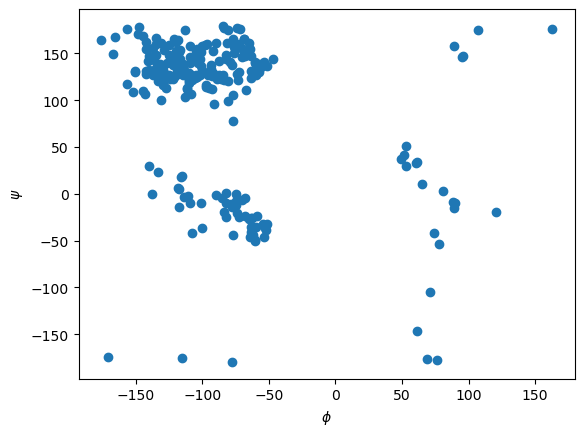

In [71]:
p=Protein(fn)
t=p.internal_coord()
#t.display()
from matplotlib import pyplot as plt
plt.scatter(t.phi, t.psi)
plt.xlabel('$\\phi$')
plt.ylabel('$\\psi$')
print("Ramachandran Plot")

#TODO: add the boundaries for popular engles, similar to the countours in https://www.mathworks.com/help/bioinfo/ref/ramachandran.html

## Object Manipulation

### Move Object
We can recenter, translate, and rotate an object.

In [72]:
p=Protein(fk)
print("Original center:", p.center(), "\n")
q=p.center_at([3.0,4.0,5.0], inplace=False)
print("New center after recentering:", q.center(), "\n")
q=p.translate([1.,0.,-1.], inplace=False)
print("New center after translate:", q.center(), "\n")
# rotate 90 degrees around axis [1,1,1]
print("RMSD before rotation:", q.rmsd(p, None, None, "CA"), "\n")
# we only rotate 5 degrees
q=p.rotate([1,1,1], 5, inplace=False)
print("Old center:", p.center(), "New center:", q.center(), "\n")
print("RMSD after rotation:", q.rmsd(p, ats="CA"), "\n")
# Warning, rotate is done using the origin as the center, that's why the rotation dramatically increase RMSD in the example above.
# most of the time, it's only meaningful if we center the molecule before rotation
rc=p.center()
q=p.center_at([0,0,0], inplace=False)
# rotate 5 degrees
q.rotate([1,1,1], 5, inplace=True)
# restore the center to the old center
q.center_at(rc, inplace=True)
# now the RMSD is much smaller
print("RMSD (center before rotate):", q.rmsd(p, None, None, "CA", align=True), "\n")

Original center: [ 15.54949999  -8.0205001  -15.39166681] 

New center after recentering: [3. 4. 5.] 

New center after translate: [ 16.54949999  -8.0205001  -16.39166681] 

RMSD before rotation: 1.414213565908629 

Old center: [ 15.54949999  -8.0205001  -15.39166681] New center: [ 15.10944354  -6.44301224 -16.52909822] 

RMSD after rotation: 2.190194411195306 

RMSD (center before rotate): 0.9061366909433874 



To reset the position of an object, use ```reset_pos()```. This will place the object center at the origin, as well as align its three PCA axes along Z, X, and Y axis, respectively.

In [149]:
p=Protein(fn)
print("Old center:", p.center(), "\n")
# rotation around a random axis direction with a random angle
p.rotate(np.random.random(3), np.random.random()*180)
p.show()
p.reset_pos()
p.show()
print("New center:", p.center())

Old center: [ 20.15256404  -5.12843199 -15.77199195] 



3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

New center: [-1.87583282e-15 -3.83693077e-16  2.47535326e-15]


### Align
It makes sense to align two objects before making RMSD measurement. Align method takes two residule lists (not residue selection) as it arguments. The default value is None, which refers to all residues.

In [ ]:
p=Protein(fn)
q=p.translate([3.,4.,0.], inplace=False)
q.rotate([1,1,1], 90, inplace=True)
p.show()
q.show()
print("RMSD before alignment:", q.rmsd(p, "ALL", "ALL", ats='CA'))
R,t=q.align(p, ats="CA")
q.show()
print("RMSD after alignment:", q.rmsd(p, ats='CA'))
print("Rotation matrix:\n", R, "\n")
print("Translation vector:", t)

RMSD usually requires a pre-alignment, therefore, we can combine the two into one by providing ```align=True``` to ```rmsd()```. Notice the coordinates of object ```p``` is changed as the side effect!

In [ ]:
p=Protein(fn)
q=p.translate([3.,4.,0.], inplace=False)
q.rotate([1,1,1], 90, inplace=True)
print("RMSD without alignment:", p.rmsd(q), "\n")
print("RMSD with built-in alignment:", p.rmsd(q, align=True), "\n")
# p has been changed by align=True
print("RMSD without alignment on the new p object:", p.rmsd(q), "\n")

### Split & Merge Objects
To split an object into multiple objects, just use ```extract```. To merge multiple structure objects into one, use ```merge```.

In [ ]:
# 1a3d.pdb is a three-chain homotrimer.
p=Protein(pwd / "example_files/1a3d.pdb")
print(p.seq_dict(), "\n")
p.show()
print("Exact chain into a new object\n")
Q=[ p.extract(x, inplace=False) for x in p.chain_id() ]
print("Object 1:", Q[0].seq_dict(), "\n")
# for object 2 & 3, computer RMSD, then align them against object 1 and print RMSD after alignment
for i,q in enumerate(Q[1:]):
    # we intentionally rename chains to A for all object, the merge method will be able to auto rename chains
    q.rename_chains({'B':'A', 'C':'A'})
    print(f"Object {i+2}:", q.seq_dict())
    print("RMSD to Object 1:", q.rmsd(Q[0], None, None, ats='N,CA,C,O'), "\n")
    q.align(Q[0], ats='N,CA,C,O')
    print("RMSD after align:", q.rmsd(Q[0], None, None, ats='N,CA,C,O'), "\n")

q=Protein.merge(Q)
print(q.seq_dict())
q.show()

### PyMOL Interface

PyMOL is a power structure visualization tool. **afpdb** provides efficient and convenient programming interface for structure computation. A easy-to-use programming interface can help combine the strenght of both tools covering both structure analysis and visualization. The ```afpdb.mypymol.PyMol``` class fills this role.

The class provides a ```run``` method enabling us to run any PyMOL commands.

In [ ]:
# create a new PyMOL engine
pm=Protein().PyMOL()
pm.cmd(f"load {fn}, myobj")
p=Protein(fn)
rs_binder, rs_Seed, t = p.rs_around("P", rs_within="H:L", dist=4)
# selecting all interface residues
rs_int = (rs_binder + p.rs(t.resi_a))
rs_str = rs_int.str(format="PYMOL", rs_name="myint")
print(rs_str)

# select CA only
print(rs_int.str(format="PYMOL", rs_name="myint", ats="CA"))

pm.run(f"""
# color by chain
as ribbon, myobj
util.cbc
# defines a selection named myint
{rs_str}
show sticks, myint
# focus on the selection
zoom myint
""")
pm.run("""deselect; save mypm.png; save mypm.pse""")
pm.close()

The generated mypm.pse is a PyMOL session file to visualize the binding interface in 3D.

We here also automatically save the image into a PNG file as below.

<img src="img/mypm.png" width="300">

As shown in this example, we can send any PyMOL commands via the ```run``` method. The input can be a single line or multiple lines. We can use ```#``` to add comments. The computation, i.e., the identification of the interface residues, can be done in **afpdb** using ```rs_around```. A residue selection object's ```str``` method casts the selection into a PyMOL selection command:

```rs_str = rs_int.str(format="PYMOL", rs_name="myint")```
turns the interface residues into the command that defines a selection object named "myint":

```select myint, (chain L and resi 33+92-95+97) or (chain H and resi 30+32+46+49-51+54+56-58+98+106-109) or (chain P and resi 1-7+9-10)```

If we only want to select CA atoms, we can do:

```rs_str = rs_int.str(format="PYMOL", rs_name="myint", ats="CA")```

This will produce:

```select myint, ((chain L and resi 33+92-95+97) or (chain H and resi 30+32+46+49-51+54+56-58+98+106-109) or (chain P and resi 1-7+9-10)) and name CA```

PyMOL command ```show sticks, myint``` and ```zoom myint``` shows the interface residues as sticks and zoom in to focus on them. We can also provide multiple PyMOL commands into one line with "; " as the concatenator. The example line is:

```deselect; save mypm.png; save mypm.pse```

Users can use all the PyMOL command they are already familiar with, but use **afpdb** for the computational tasks that are not straightforward to do in PyMOL. Destroy the PyMOL() instance with ```close()```, when it is no longer needed to save resource.

Note: If we already have PyMOL commands saved into a text file, we can also use ```pm.script(script_file_name)``` to execute it.

## AI Protein Design

One effective AI protein design strategy involves generating hypothetical binder backbone structures based on a target protein, followed by using inverse folding AI models to create binder sequences. These designs can then be validated using structure prediction models like AlphaFold. In order to archieve successful designs, thousand of protein structures need to be manipulated within a project. **afpdb** aims to increase the productivity for such large-scale AI protein design efforts.

In this section, we demonstrate two real use cases on how **afpdb** tools help in AI protein design processes.

### Missing Residue Modeling

In evaluating protein structure prediction models such as AlphaFold, the true experimental structure ```p_exp``` may contain missing residues. We often replace missing residues with Glycine for AlphaFold modeling. When align the predicted structure ```p_af``` against ```p_exp```, we need to exclude those added G residues, as they do not exist in ```p_exp```.

The example below first created a fake experimental ```p_exp``` with five missing residues, and a fake AF-predicted ```p_af``` with five extra Glycines. ```p_exp``` contains 106 residues with L15-19 missing. ```p_af``` contains 111 residues with five extra Gs.

From ```p_exp```, ```rsi_missing()``` returns a residue selection object that can be used to point at the extra G residues in ```p_af```. Methods ```align``` and ```rmsd``` can then be done with those extra residues excluded.

In [ ]:
p=Protein(fn)
miss_residues="L15-19"

# create an experimental structure for chain L with residues L15-19 missing
p_exp=p.extract( ~ p.rs(miss_residues) & "L")
print(p_exp.seq(), "\n")
print("Notice five residues XXXXX corresponds to position 15-19\n")

af_seq=p_exp.seq().replace("X", "G")
print(af_seq, "\n")
print("We run AlphaFold prediction using af_seq, i.e., replacing missing residues with Gly ...\n")

# Create a fake AlphaFold predicted structure, by changing the missing residues to Glycine
p_af=p.extract("L") # extract chain L
rs=p_af.rs(miss_residues)
print(rs)
p_af.data.aatype[rs.data]=RS.i("G") # set residue type to Gly
# np.ix_ select all rows in rs.data and all columns in ~ATS("N,CA,C,O")).data
p_af.data.atom_mask[np.ix_(rs.data, (~ATS("N,CA,C,O")).data)]=0 # Gly does not have side chain atoms
print("Pretend p_af is the output of AlphaFold prediction\n")
print("Verify the missing resiudes are not missing in p_af, they are Gs:\n")
print(p_af.seq(), "\n")

print(f"# of residues: p_exp={len(p_exp)}, p_af={len(p_af)}")

# we now need to align the common residues, excluding miss_residues as they do not exist in p_exp
# obtain a missing residue indices from p_exp
print(p_exp.seq(), "\n")
# notice rsi_ returns an integer array, not a residue selection object, as the missing indices are not meaningful for p_exp
rsi=p_exp.rsi_missing()
# warning: do not use rsi on p_exp, as rsi contains non-existing residue indices!!!
# cast rsi into a RS object for object p_af
rs_miss=RS(p_af, rsi)
# now rs_miss is meaningful, as they point to the 5 Gs
print(rs_miss, rs_miss.seq(), "\n")

# now align the two structure and measure RMSD
print(p_exp.rmsd(p_af, rl_b=~rs_miss, ats="CA", align=True), "\n")

TODO: we will implement a fold() method, which uses META for prediction, so we do not have to deal with the hack above.

### Create Side Chains for de novo Designed Proteins

In the current AI-based protein design, RFDiffusion only generates a protein backbone. The output PDB file only contains coordinates for N, CA, C, O atoms. Often times, RFDiffusion works on an input template and was used to design only part of the structure. For example, in an antibody design application, RFDiffusion may be only used to redesign the CDR loops, while leaving the framework residues and structures untouched. In the example below, we use RFDiffusion to design a partial structure, e.g., CDR H3 loops with the rest of the antibody sequence fixed. For convenience, let us refer to those fixed residues approximately as framework residues and the CDR H3 loop as CDR residues without creating confusion. 

In the output PDB file generated by RFDiffusion, no sidechain atom exists, even for those framework residues. The generated CDR H3 backbone are represented by glycine residues. ProteinMPNN will preserve the input framework residues, while proposing CDR H3 residues to replace those glycines. To visualize the full-atom model of the design antibody-antigen complex structure, we can use AlphaFold to predict the structure from the ProteinMPNN sequences. However, AlphaFold prediction is time consuming and the predicted structure can be very different from the desired PDB structure due to the limited prediction accuracy on Ab-Ag complexes.

The method ```thread_sequence()``` helps us rapidly create a full-atom structure by threading the ProteinMPNN-generated sequence onto the RFDiffusion backbone-only structure. When the ProteinMPNN sequence is threaded onto the PDB backbone template, the side chain coordinates of those framework residues are now generated by PyMOL, which can be very different from their original known coordinates. For this reason, ```thread_sequence()``` takes an additional argument ```side_chain_pdb```, which specifies the original PDB file that contains the side chain atoms for the framework residues (this is the PDB file used as the input for RFDiffusion). With this additonal input, the side chain coordinates for framework residues in the original PDB structure will be used instead of relying on PyMOL generation. Argument ```seq2bfactor=True``` maps the upper/lower-case of the input sequence onto b-factors (1.0/0.5), so that we can use b-factor to distinguish the redesigned residues (lower case) from those residues (upper case) preserved from the input template.

There are details inside the method that made use of several other **afpdb** methods. For example:
* The predicted structure needs to be aligned with the ```side_chain_pdb``` first, before we are able to clone the coordinates of the side chain atoms. This is because the original PDB structure and the RFDiffusion-generated structure are not aligned by default.
* When RFDiffusion generates its output, chains were named A, B, C, etc. with the original chain names lost. As RFDiffusion can hallucinate new chains that do not exist in the original structure, it may not be able to preserve the original chain names even if it likes to. For this reason, we also need to provide a ```chain_map``` argument, so that the threading code knows how to map the wild-type chain names into the RFDiffusion chain names in order to align them correctly. 

In [ ]:
# we first mimic a backbone-only structure, by changing all residues to Gly
q=Protein(pwd / "example_files/5cil_rfdiffuse_H3.pdb")
# rs_missing_atoms returns all residues where their sidechain atoms are missing
no_sc=q.rs_missing_atoms()
print("All non-Gly residues have missing side-chain atoms:", util.unique(no_sc.seq()), "\n")
seq_MPNN={
          'A':'EIVLTQSPGTQSLSPGERATLSCRASQSVGNNKLAWYQQRPGQAPRLLIYGASSRPSGVADRFSGSGSGTDFTLTISRLEPEDFAVYYCQQYGQSLSTFGQGTKVEVKRTV',
          'B':'NWFDITNWLWYIK',
          'C':'VQLVQSGAEVKRPGSSVTVSCKASGGSFSTYALSWVRQAPGRGLEWMGGVIPLLTITNYAPRFQGRITITADRSTSTAYLELNSLRPEDTAVYYCARhlvrtvgsgsnpemgdvvWGQGTLVTVSS'
        }
# we thread seq_MPNN onto RFDiffusion output structure q
# output a new PDB file: test.pdb
# copy sidechains of framework residues from template fn
# map the A/B/C chain names in the RFDiffusion structure to the L/P/H chains in the template fn
# seq2bfactor=True means we assign b-factor of value 0.5 for lower-cased seq_MPNN residues (those are CDR H3 residues redesigned)
# framework residues (upper case) have b-factor of value 1.0.
q.thread_sequence(seq_MPNN, 'test.pdb', seq2bfactor=True, side_chain_pdb=fn, chain_map={"H":"C", "L":"A", "P":"B"})
q=Protein("test.pdb")
print("\nResidues with missing atoms:", q.rs_missing_atoms(), "\n")
q.show(color="b")

In the RFDiffusion output file 5cil_rfdiffuse_H3.pdb, all 250 residues have missing atoms due to their missing side chains. After threading using the wild-type PDB 5cil.pdb as the template, we copy the side chain coordinates for all upper-case residues except the lower-case residues in the H3 CDR loop. The side chain atoms for the H3 loop are generated by PyMOL by replacing Glycine with corresponding ProteinMPNN-generated residues. At the end, the final output test.pdb contains all atoms, therefore, no residue has missing atoms.

## Developer's Notes
### Selection
When creating a method that takes a selection argument named 'rs', the first step is to convert it into an internal selection object using:
```rs = self.rs(rs)```, this will convert the argument into a RS object, which has its ```data``` member storing the residue indices. Similarly, if we have an atom selection argument named 'ats', do ```ats=self.ats(ats)```. Similarly, if we take a residue list object, we do ```rl=self.rl(rl)```. When we use a residue/atom selection to index atom_positions or atom_mask, check if the selection is empty/full with ats.is_empty() and ats.is_full(). Empty selection often implies an error on the users' side, a full selection means you can skip the indexing, as the original array is already good.

Please use ```extract()``` as an example to see how we support selection arguments.

### Change in residue/chain
The Protein class contains a data structure called ```res_map```, which is a dictionary that maps a full residue name "{chain}{residue_id}{code}" into its internal ndarray index. A few methods rely on this mapping. Therefore, whenever a method renames a chain, changes chain orders, mutates a residue, or changes the full residue name and its internal index, ```self._make_res_map()``` should be called at the end. This is also needed in ```extract()``` as the underlying arrays have been changed.

### Residue Identifier
When outputting a dataframe containing a residue, our recommendation is to provide all residue ID formats. This includes chain, resn, resn_i, resi. Please use ```rs_dist``` as an example. We often use the resi column to create a Residue List object, then use its ```name, namei, chain, aa``` methods to add additional residue annotation data. See the example under ```rs_dist()```.

### inplace
To support ```inplace```, the idiom is to use: ```obj = self if inplace else self.clone()```, then use obj to manipulate the structure.

### Caution
When we add a new method, please keep in mind that the residue index may not start from 1, a residue index may contain insertion code, there can be gaps in the residue index (missing residues), the integer part of the residue index may not be unique within a chain (e.g. 6A and 6B). You should use the file "fk" to test your method. Please also add a corresponding test method into ```tests/test_all.py```.